# Preparing Catalogs for Metrics Analysis

In [1]:
# Common Libraries
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os
import json
import glob
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# import seaborn as sns
import pandas as pd
import sys
# allows us to import from the custom configs directory w/o affecting deepdisc library imports
sys.path.insert(0, '/u/yse2/deepdisc/configs')
print(sys.path)
# Astropy imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import make_lupton_rgb
from typing import List, NamedTuple
from multiprocessing import Pool
from itertools import chain
from scipy.optimize import curve_fit
# Matplotlib and other libraries
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from tqdm import tqdm

['/u/yse2/deepdisc/configs', '/projects/bdsp/miniconda3/envs/ddbtknv/lib/python310.zip', '/projects/bdsp/miniconda3/envs/ddbtknv/lib/python3.10', '/projects/bdsp/miniconda3/envs/ddbtknv/lib/python3.10/lib-dynload', '', '/u/yse2/.local/lib/python3.10/site-packages', '/u/yse2/deepdisc/src', '/projects/bdsp/miniconda3/envs/ddbtknv/lib/python3.10/site-packages']


In [2]:
root_dir = os.path.expanduser('~/lsst_data/')
folder = 'annotations_lvl5'
test_data_fn = f'{root_dir}{folder}/test_8k.json'
test_data = pd.read_json(test_data_fn)
test_cats_dir = f'{root_dir}test_cats_lvl5/test_8k/'
run_name = 'lsst5_30k_4h200_bs192_ep50'
print(f"Loaded test data from {test_data_fn} with {len(test_data)} images.")
print(f"Test catalogs directory: {test_cats_dir}")
print(f"Run name: {run_name}")

Loaded test data from /u/yse2/lsst_data/annotations_lvl5/test_8k.json with 8571 images.
Test catalogs directory: /u/yse2/lsst_data/test_cats_lvl5/test_8k/
Run name: lsst5_30k_4h200_bs192_ep50


# Getting LSST Truth and Detection Catalog Info of Area Covered by Test Set

Since the test set only has 8000 cutouts, it covers a much a smaller area of the overall sky area we have available. As such, we need to find the truth and detected objects that exist within each of these cutouts. We can do this trivially since each cutout has the keys: `truth_cat_path` and `det_cat_path` that lead to a catalog containing the ground truth objects and detected objects respectively within that cutout. 

In [3]:
det_cat_paths = test_data.det_cat_path.tolist()
truth_cat_paths = test_data.truth_cat_path.tolist()
file_names = test_data.file_name.tolist()

In [4]:
def read_json(path, file_name):
    return pd.read_json(path).assign(file_name=file_name) # add col with file name for each cat

def create_all_cats(cat_paths, file_names, cat_type):
    print(f"Processing {len(cat_paths)} {cat_type} catalog files in test set which should match the {len(test_data)} cutouts in test set.")
    cpu_count = len(os.sched_getaffinity(0))
    print(f"Using {cpu_count} CPUs to load in {len(cat_paths)} dataframes...")
    with Pool(processes=cpu_count) as pool:
        all_cats = pool.starmap(read_json, zip(cat_paths, file_names))
    print(f"Successfully loaded {len(all_cats)} {cat_type} catalogs which should again match the {len(test_data)} cutouts in test set.")
    print(f"The total number of LSST {cat_type} objects across the same area as the test set is (including potential duplicates): {sum([len(cat) for cat in all_cats])}")
    return all_cats

In [5]:
all_det_cats = create_all_cats(det_cat_paths, file_names, 'detection') # ~17.5 s w/ 32 CPUs

Processing 8571 detection catalog files in test set which should match the 8571 cutouts in test set.
Using 32 CPUs to load in 8571 dataframes...
Successfully loaded 8571 detection catalogs which should again match the 8571 cutouts in test set.
The total number of LSST detection objects across the same area as the test set is (including potential duplicates): 271146


In [7]:
all_truth_cats = create_all_cats(truth_cat_paths, file_names, 'truth') # ~41s w/ 32 CPUs

Processing 8571 truth catalog files in test set which should match the 8571 cutouts in test set.
Using 16 CPUs to load in 8571 dataframes...
Successfully loaded 8571 truth catalogs which should again match the 8571 cutouts in test set.
The total number of LSST truth objects across the same area as the test set is (including potential duplicates): 1190077


In [7]:
all_det_cats[5]

,clean,mag_y,psf_fwhm_r,patch,mag_g,snr_y_cModel,snr_i_cModel,extendedness,mag_z_cModel,mag_u,...,tract,mag_u_cModel,psf_fwhm_g,snr_g_cModel,psf_fwhm_y,ra,mag_i,cutout_x,cutout_y,file_name
0,True,26.118981,0.849006,"0,0",27.843334,0.888576,7.724825,0,25.120004,29.071679,...,3256,28.509775,0.897332,2.036781,1.165917,51.415989,25.733061,46.890235,52.677475,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
1,True,24.498444,0.851600,"0,0",27.001259,4.163064,14.415524,0,25.104548,26.550808,...,3256,26.452065,0.885042,4.979995,1.165919,51.415414,25.055598,54.123365,106.336047,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
2,True,23.175374,0.849927,"0,0",23.292234,13.840290,69.615816,1,22.862648,23.425320,...,3256,23.134348,0.880423,141.302217,1.164576,51.411999,23.367901,100.066441,111.854943,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
3,True,25.278589,0.854691,"0,0",27.647576,1.874402,7.491906,1,24.793155,26.664129,...,3256,26.324374,0.880422,2.620869,1.164741,51.410110,25.933101,125.286164,134.222374,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
4,True,26.283804,0.849058,"0,0",26.885120,1.076425,1.964117,1,25.259867,28.922489,...,3256,27.562501,0.897335,6.376415,1.166258,51.418940,27.183071,7.518083,14.033777,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
5,True,27.254614,0.848819,"0,0",25.949210,0.578475,4.038777,1,26.626478,25.697995,...,3256,25.697575,0.897335,12.460572,1.165901,51.418295,26.466873,16.094239,26.155134,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
6,True,25.955153,0.853134,"0,0",26.944979,1.121391,2.175269,0,NaN,28.967999,...,3256,29.978628,0.895885,5.145243,1.166258,51.413854,27.142260,75.650192,50.694160,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
7,True,25.502125,0.859945,"0,0",26.965216,1.310367,2.527285,1,NaN,27.647684,...,3256,27.613816,0.880421,5.104333,1.165367,51.410511,27.083787,119.987742,123.876297,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
8,True,27.792826,0.859945,"0,0",26.924830,0.042302,2.987487,1,25.984114,28.292132,...,3256,28.336273,0.885053,5.507847,1.166258,51.416012,26.797147,45.765790,139.950651,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
9,True,24.730687,0.851861,"0,0",25.443697,3.324235,10.553304,1,24.908183,25.779641,...,3256,25.641363,0.895878,20.094099,1.164652,51.414733,25.416435,64.253618,4.041911,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...


In [7]:
all_truth_cats[5]

,id,mag_r,patch,flux_g,tract,mag_z,dec,mag_y,rv,ra,...,size_disk_true,ellipticity_1_true,bulge_to_total_ratio_u,bulge_to_total_ratio_g,bulge_to_total_ratio_r,bulge_to_total_ratio_z,bulge_to_total_ratio_y,cutout_x,cutout_y,file_name
0,10252628048,28.496267,"0,0",4.916702,3256,26.826593,-41.595325,26.513708,3.1,51.409893,...,0.161937,0.065590,0.047988,0.096572,0.164494,0.188210,0.199842,128.945681,55.352002,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
1,10252657732,28.406851,"0,0",4.928853,3256,26.703934,-41.592929,26.343491,3.1,51.417757,...,0.152574,-0.122857,0.000000,0.000000,0.000000,0.000000,0.000000,22.659198,97.479638,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
2,10252340453,28.371241,"0,0",8.583076,3256,27.038517,-41.594278,26.943630,3.1,51.411993,...,0.116248,0.001731,0.000000,0.000000,0.000000,0.000000,0.000000,100.500622,73.925935,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
3,10252375187,28.114119,"0,0",13.727154,3256,26.956146,-41.592612,26.937361,3.1,51.415365,...,0.086533,-0.307650,0.000000,0.000000,0.000000,0.000000,0.000000,54.818338,103.484783,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
4,10252711813,28.570383,"0,0",11.994190,3256,27.718304,-41.597515,27.686623,3.1,51.416859,...,0.093805,-0.020570,0.495171,0.505748,0.557099,0.688295,0.711420,35.525047,15.040665,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,10270702013,28.641396,"0,0",7.375359,3256,28.808399,-41.592062,28.748672,3.1,51.418593,...,0.089938,-0.340925,0.000000,0.000000,0.000000,0.000000,0.000000,11.258208,112.986415,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
152,10270205016,27.843159,"0,0",11.119020,3256,27.641533,-41.590722,27.616383,3.1,51.411025,...,0.148753,-0.103730,0.057103,0.452467,0.711013,0.809498,0.817769,112.935474,138.078468,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
153,10270222447,27.645451,"0,0",18.898119,3256,27.753733,-41.595311,27.699511,3.1,51.413697,...,0.147661,-0.069770,0.072362,0.404206,0.546928,0.617605,0.630955,77.727649,55.108718,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...
154,10270234084,27.807224,"0,0",15.080068,3256,27.122614,-41.593258,26.985540,3.1,51.418996,...,0.523422,-0.010744,0.475318,0.548213,0.667687,0.879122,0.888470,6.044783,91.392096,/u/yse2/lsst_data/truth/51.37_-41.5/c63_51.37_...


Text(0.5, 1.0, 'Detections and Ground Truth Objects of Random Cutout #10')

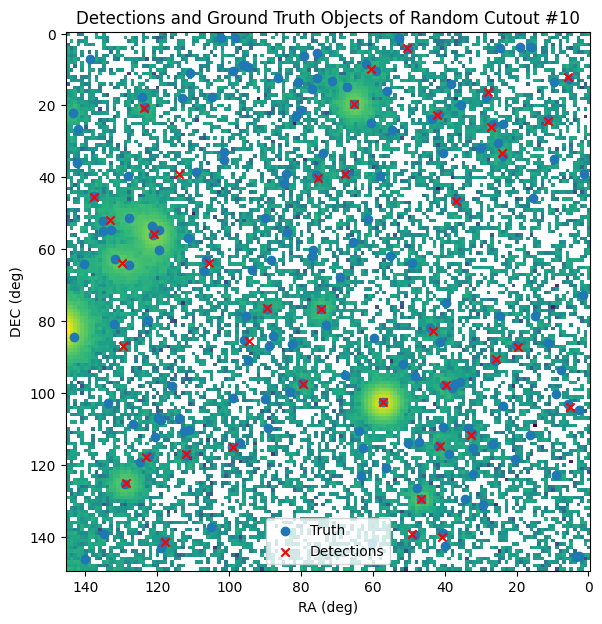

In [15]:
# let's do a quick check of the detections vs truth for a random cutout
rand_cutout_idx = 10
plt.figure(figsize=(7,7))
plt.imshow(np.load(all_truth_cats[rand_cutout_idx]['file_name'][0])[3, :, :], norm=colors.LogNorm())
plt.scatter(all_truth_cats[rand_cutout_idx]['cutout_x'].values, all_truth_cats[rand_cutout_idx]['cutout_y'].values, label='Truth')
plt.scatter(all_det_cats[rand_cutout_idx]['cutout_x'].values, all_det_cats[rand_cutout_idx]['cutout_y'].values, marker='x', c='red', label='Detections')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.gca().invert_xaxis()
plt.ticklabel_format(style='plain', useOffset=False) # prevent scientific notation
plt.legend()
plt.title(f'Detections and Ground Truth Objects of Random Cutout #{rand_cutout_idx}')

Since we have $>200k$ objects and ~$1.1$ million objects across the detection catalogs and truth catalogs respectively, we need a fast way to combine all of these objects into one big dataframe. Using `pd.concat()` for a large number of dataframes is really slow because it repeatedly copies DataFrame indices and builds the result incrementally. Instead, we use `itertools.chain.from_iterable()` to efficiently flatten each column across all data, then construct a single DataFrame from the resulting dictionary. This is way faster and more memory-efficient.

In [8]:
def concat_all_cats(all_cats, cat_type):
    # build dict col-by-col
    col_names = all_cats[0].columns.tolist()
    print(f"Columns of {cat_type} catalog: {col_names}")
    df_dict = {}
    for col in col_names:
        df_dict[col] = list(chain.from_iterable(df[col] for df in all_cats))
    full_cat = pd.DataFrame(df_dict)
    print(f"Successfully concatenated {cat_type} catalogs into one catalog with {len(full_cat)} total objects.")
    return full_cat

## LSST Detection Catalog

In [9]:
full_det_cat = concat_all_cats(all_det_cats, 'detection') # took ~20.5s

Columns of detection catalog: ['clean', 'mag_y', 'psf_fwhm_r', 'patch', 'mag_g', 'snr_y_cModel', 'snr_i_cModel', 'extendedness', 'mag_z_cModel', 'mag_u', 'mag_r_cModel', 'good', 'mag_i_cModel', 'psf_fwhm_u', 'dec', 'blendedness', 'y', 'parentObjectId', 'psf_fwhm_z', 'snr_u_cModel', 'snr_z_cModel', 'mag_y_cModel', 'objectId', 'snr_r_cModel', 'psf_fwhm_i', 'x', 'mag_g_cModel', 'mag_z', 'mag_r', 'tract', 'mag_u_cModel', 'psf_fwhm_g', 'snr_g_cModel', 'psf_fwhm_y', 'ra', 'mag_i', 'cutout_x', 'cutout_y', 'file_name']
Successfully concatenated detection catalogs into one catalog with 271146 total objects.


In [10]:
print(len(np.unique(full_det_cat.objectId.values)), "unique objects in detection catalog that covers the same cutout areas as the test set.")

271146 unique objects in detection catalog that covers the same cutout areas as the test set.


In [11]:
# from this schema: https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md
# we also filter out objs that aren't 'clean'
# 'clean' is only True if the source has no flagged pixels (such as interpolated, saturated, edge, clipped) 
# and isn't skipped by the deblender (due to blending/segmentation failures)
clean_det_cat = full_det_cat[(full_det_cat['clean'] == True)]
print(len(np.unique(clean_det_cat.objectId.values)), f"unique objects in the clean detection catalog removing {(1 - len(clean_det_cat)/len(full_det_cat))*100:.2f}% of sources.")

270107 unique objects in the clean detection catalog removing 0.38% of sources.


In [12]:
clean_det_cat.columns

Index(['clean', 'mag_y', 'psf_fwhm_r', 'patch', 'mag_g', 'snr_y_cModel',
       'snr_i_cModel', 'extendedness', 'mag_z_cModel', 'mag_u', 'mag_r_cModel',
       'good', 'mag_i_cModel', 'psf_fwhm_u', 'dec', 'blendedness', 'y',
       'parentObjectId', 'psf_fwhm_z', 'snr_u_cModel', 'snr_z_cModel',
       'mag_y_cModel', 'objectId', 'snr_r_cModel', 'psf_fwhm_i', 'x',
       'mag_g_cModel', 'mag_z', 'mag_r', 'tract', 'mag_u_cModel', 'psf_fwhm_g',
       'snr_g_cModel', 'psf_fwhm_y', 'ra', 'mag_i', 'cutout_x', 'cutout_y',
       'file_name'],
      dtype='object')

In [ ]:
# Jan 14th - need to make sure that the catalog you save has the flux and shape columns in the detection catalog (should be 139 columns in total)
# if not go to NERSC and grab them from the full det cat using objectId column and merge them in here before saving
# let's save this clean det catalog since we no longer need to filter it again
clean_det_cat = clean_det_cat.reset_index(drop=True) # reset index before saving
clean_det_cat.to_json(f'{test_cats_dir}test_det_cat.json', orient='records')

### Choosing Magnitude Column

From [GCR Schema of Object Catalog](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-object-catalogs), we have

- `mag_<band>`: Point-source model magnitude in `<band>`
- `mag_<band>_cModel`:	composite model (cModel) magnitude in `<band>`, fitted by cModel ([Doxygen for cModel fitting](http://doxygen.lsst.codes/stack/doxygen/xlink_main_2022_07_07_08.22.14/modelfit_c_model.html))

So, ideally, we use `psFlux` / `mag_<band>` for stars and `cModelFlux` / `mag_<band>_cModel` for galaxies. So, let's take a look at the actual values for these columns.

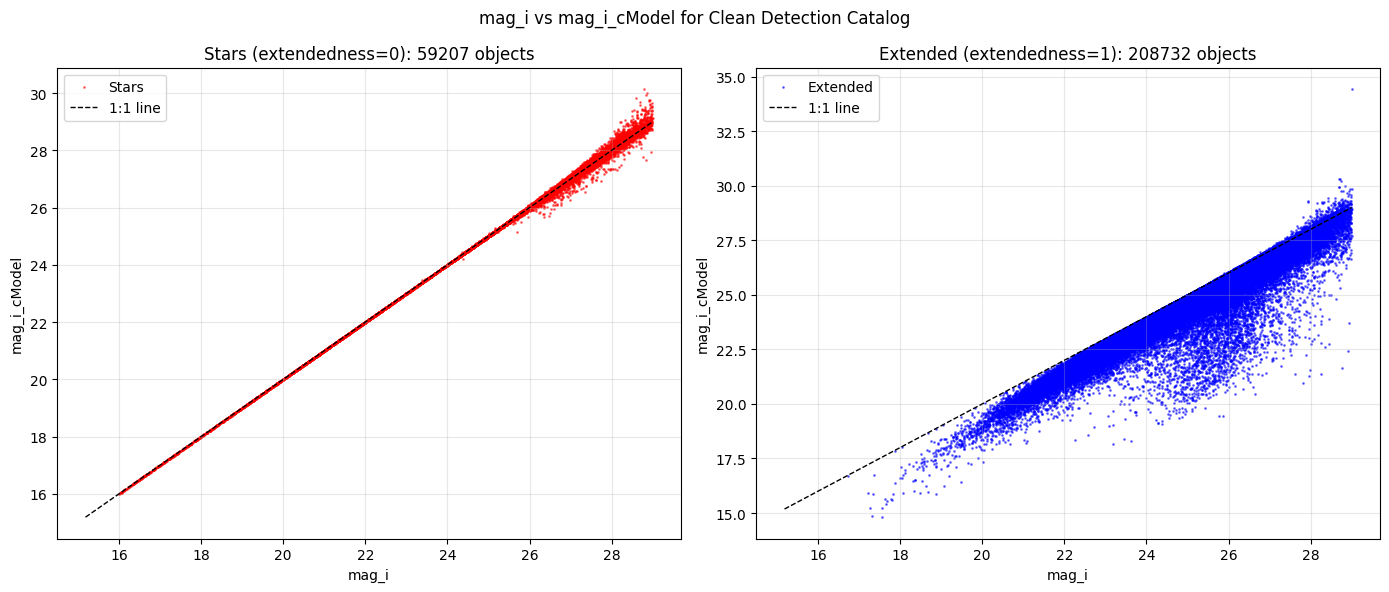

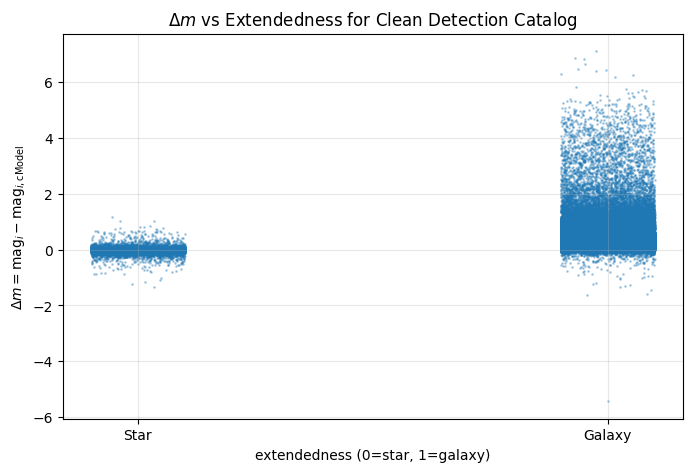

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# Stars (extendedness == 0)
stars = clean_det_cat[clean_det_cat['extendedness'] == 0]
ax1.scatter(stars['mag_i'], stars['mag_i_cModel'], s=1, alpha=0.5, color='red', label='Stars')
ax1.plot([clean_det_cat['mag_i'].min(), clean_det_cat['mag_i'].max()], 
         [clean_det_cat['mag_i'].min(), clean_det_cat['mag_i'].max()], 
         'k--', lw=1, label='1:1 line')
ax1.set_xlabel('mag_i')
ax1.set_ylabel('mag_i_cModel')
ax1.set_title(f'Stars (extendedness=0): {len(stars)} objects')
ax1.legend()
ax1.grid(True, alpha=0.3)
# Extended sources (extendedness == 1) aka galaxies
extended = clean_det_cat[clean_det_cat['extendedness'] == 1]
ax2.scatter(extended['mag_i'], extended['mag_i_cModel'], s=1, alpha=0.5, color='blue', label='Extended')
ax2.plot([clean_det_cat['mag_i'].min(), clean_det_cat['mag_i'].max()], 
         [clean_det_cat['mag_i'].min(), clean_det_cat['mag_i'].max()], 
         'k--', lw=1, label='1:1 line')
ax2.set_xlabel('mag_i')
ax2.set_ylabel('mag_i_cModel')
ax2.set_title(f'Extended (extendedness=1): {len(extended)} objects')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.suptitle('mag_i vs mag_i_cModel for Clean Detection Catalog')
plt.tight_layout()

# Plot delta_m = mag_i - mag_i_cModel vs extendedness with jitter for better visualization
plt.figure(figsize=(8, 5))
delta_m = clean_det_cat['mag_i'] - clean_det_cat['mag_i_cModel']
# Add small random jitter to extendedness for visualization
jitter = np.random.uniform(-0.1, 0.1, size=clean_det_cat.shape[0])
x_jittered = clean_det_cat['extendedness'] + jitter
plt.scatter(x_jittered, delta_m, s=1, alpha=0.3)
plt.gca().set_xticks([0, 1])
plt.gca().set_xticklabels(['Star', 'Galaxy'])
plt.xlabel('extendedness (0=star, 1=galaxy)')
plt.ylabel(r'$\Delta m = \mathrm{mag}_i - \mathrm{mag}_{i,\mathrm{cModel}}$')
plt.title(r'$\Delta m$ vs Extendedness for Clean Detection Catalog')
plt.grid(True, alpha=0.3)

As we can see, our “Stars (extendedness=0)” panel shows a tight near-1:1 relation, meaning PSF and cModel fluxes agree for point sources, with only modest scatter at the faint end. However, the “Extended (extendedness=1)” panel shows a broad wedge with many points below the 1:1 line (i.e., mag_i systematically fainter than mag_i_cModel), consistent with cModel capturing more total flux than a PSF fit for resolved galaxies that misses extended light.

The $\Delta m$ vs extendedness plot shows a clean separation with galaxies shifted to positive $\Delta m$ which makes sense since `mag_i`'s for galaxies were systematically fainter than mag_i_cModel so $\Delta$ m = mag_i - mag_i_cModel > 0 demonstrating that extended sources have more model (cModel) flux than PSF flux.

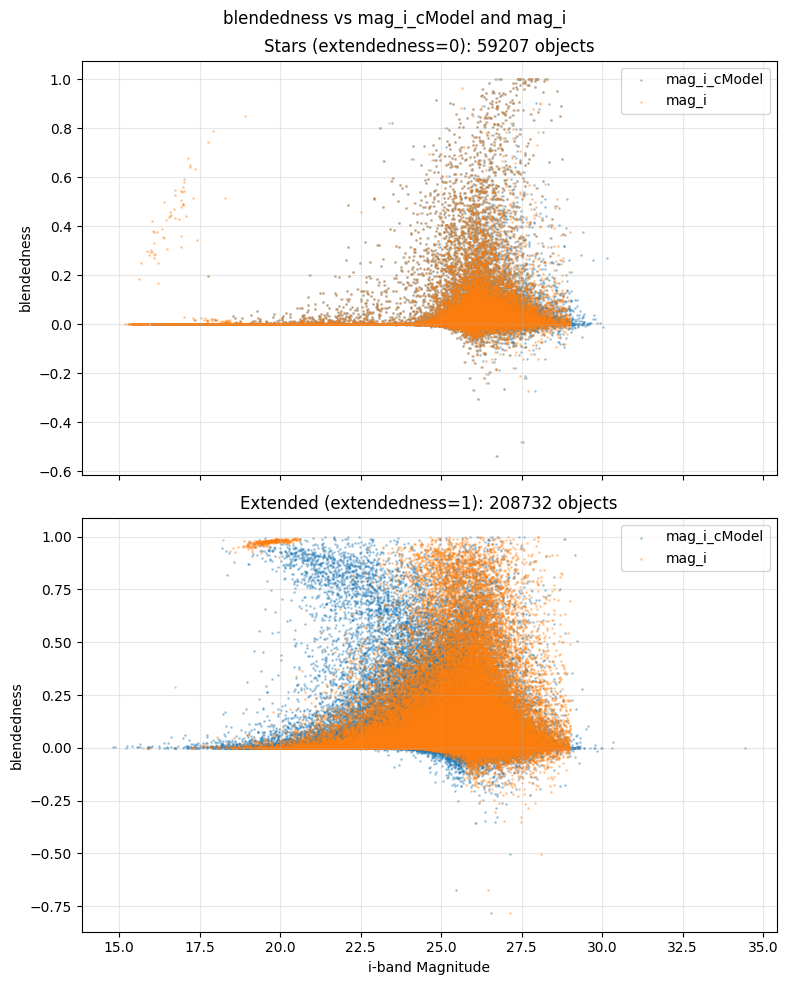

In [96]:
# blendedness vs mag_i_cModel, mag_i for stars and galaxies, shared x-axis, 2 rows 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Stars (extendedness == 0)
ax1.scatter(stars['mag_i_cModel'], stars['blendedness'], s=1, alpha=0.3, label='mag_i_cModel')
ax1.scatter(stars['mag_i'], stars['blendedness'], s=1, alpha=0.3, label='mag_i')
ax1.set_ylabel('blendedness')
ax1.set_title(f'Stars (extendedness=0): {len(stars)} objects')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Galaxies (extendedness == 1)
ax2.scatter(extended['mag_i_cModel'], extended['blendedness'], s=1, alpha=0.3, label='mag_i_cModel')
ax2.scatter(extended['mag_i'], extended['blendedness'], s=1, alpha=0.3, label='mag_i')
ax2.set_ylabel('blendedness')
ax2.set_xlabel('i-band Magnitude')
ax2.set_title(f'Extended (extendedness=1): {len(extended)} objects')
ax2.legend()
ax2.grid(True, alpha=0.3)

fig.suptitle('blendedness vs mag_i_cModel and mag_i')
plt.tight_layout()


In [67]:
# does clean_det_cat['mag_i'] have any NaNs?
print(clean_det_cat['mag_i'].isna().sum(), " NaNs in mag_i")
# does clean_det_cat['mag_{band}_cModel'] have any NaNs for all bands?
band = ['u', 'g', 'r', 'i', 'z', 'y']
for b in band:
    print("---")
    print(clean_det_cat[f'mag_{b}_cModel'].isna().sum(), f" NaNs in mag_{b}_cModel")
    # are those NaNs for stars aka extendedness == 0?
    print(len(clean_det_cat[clean_det_cat[f'mag_{b}_cModel'].isna() & (clean_det_cat['extendedness'] == 0)]), f" NaNs in mag_{b}_cModel for stars")

0  NaNs in mag_i
---
41812  NaNs in mag_u_cModel
11652  NaNs in mag_u_cModel for stars
---
4518  NaNs in mag_g_cModel
1444  NaNs in mag_g_cModel for stars
---
1822  NaNs in mag_r_cModel
596  NaNs in mag_r_cModel for stars
---
858  NaNs in mag_i_cModel
199  NaNs in mag_i_cModel for stars
---
20432  NaNs in mag_z_cModel
7024  NaNs in mag_z_cModel for stars
---
29447  NaNs in mag_y_cModel
9599  NaNs in mag_y_cModel for stars


So, which magnitude column do we choose? We choose to use the PSF-based magnitude `mag_i` as we want a stable “detection-depth / completeness” axis. Completeness is usually parameterized by something close to a PSF SNR / PSF mag limit since the coadd-depth products and many depth definitions are effectively “idealized PSF magnitude limits". So, `mag_i` is the safer bet especially since we have 0 NaNs allowing us to keep all the objects.

### Choosing Limiting Magnitude

Text(0.5, 1.0, 'Mag $i$ Distribution of LSST Detection Catalog Objects (270107 objs)')

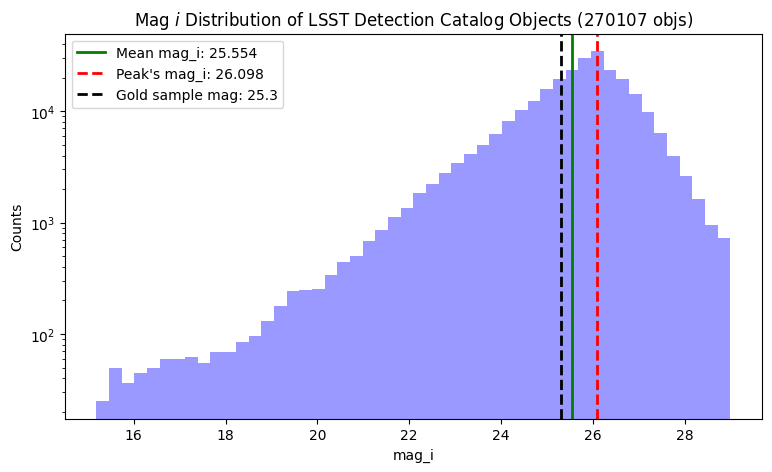

In [12]:
counts, bin_edges = np.histogram(clean_det_cat[np.isfinite(clean_det_cat['mag_i'])]['mag_i'], bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.axvline(np.mean(clean_det_cat['mag_i']), color='green', linestyle='solid', 
            linewidth='2', label=f'Mean mag_i: {np.mean(clean_det_cat["mag_i"]):.3f}')
plt.axvline(peak_mag, color='red', linestyle='dashed', linewidth='2',
            label=f"Peak's mag_i: {peak_mag:.3f}")
plt.axvline(25.3, color='black', linestyle='--', linewidth='2', label=f'Gold sample mag: 25.3')
plt.hist(clean_det_cat['mag_i'], bins=50, alpha=0.4, color='blue')
plt.yscale('log')
plt.legend()
plt.title(f"Mag $i$ Distribution of LSST Detection Catalog Objects ({len(clean_det_cat)} objs)")

Since we'll be using the LSST detection catalog as our benchmark, we need to either use the nominal value for, or empirically find, the limiting magnitude. Let's explore both cases.

Since we're not using 10-year simulated coadds, we will have to calculate the mag limit using the nominal 5-sigma mag provided by [Rubin's key numbers](https://rubinobservatory.org/for-scientists/rubin-101/key-numbers).

In [13]:
# same for all SNR levels
def nom_mag_limit(baseline_mag_5sigma_10yr, years, baseline_snr=5, target_snr=5):
    """
    Calculate truth catalog magnitude cut at Rubin's nominal 5-sigma depth adjusted 
    for the specified number of observation years. This cut is intended to be used consistently for defining the faint 
    limit of the truth sample for analysis (e.g., completeness).

    Parameters:
    baseline_mag_5sigma_10yr (float): 10-year 5-sigma depth (e.g., 26.8 for i-band) from Rubin key values
    years (float): Analysis time baseline in years
    
    Returns:
    float: Magnitude cut for truth catalog
    """
    time_factor = np.sqrt(10 / years) # represents (sqrt(N_obs_10yr) / sqrt(N_obs_years))
    # delta_mag = 2.5 * log10(SNR_ratio)
    # SNR_ratio corresponds to 1 / time_factor for reaching the same SNR
    m_cut = baseline_mag_5sigma_10yr - 2.5 * np.log10(time_factor)
    # adjust for change in SNR threshold
    snr_ratio = baseline_snr / target_snr
    final_mcut = m_cut + 2.5 * np.log10(snr_ratio)
    return final_mcut

baseline_mag_5sigma_10yr_i = 26.8  # From Rubin key numbers
years = 5
given_mag_limit = nom_mag_limit(baseline_mag_5sigma_10yr_i, years)
print(f"Limiting Magnitude: mag_i <= {given_mag_limit:.3f}")  # 26.42

Limiting Magnitude: mag_i <= 26.424


Text(0.5, 1.0, 'Mag $i$ Distribution of LSST Detection Catalog Objects (270107 objs)')

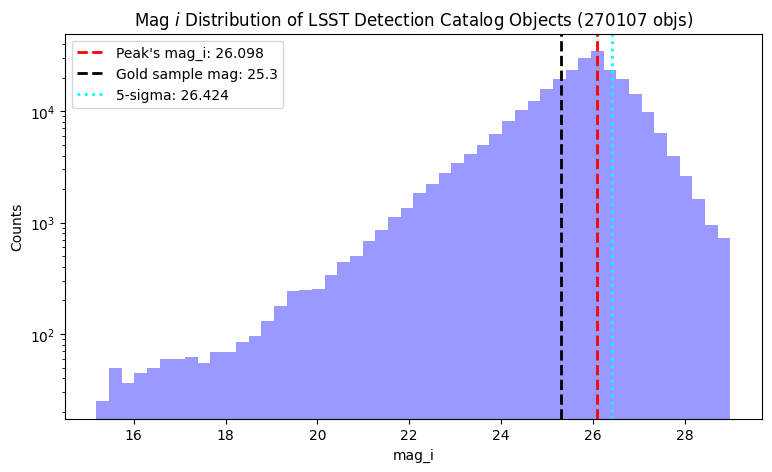

In [14]:
counts, bin_edges = np.histogram(clean_det_cat[np.isfinite(clean_det_cat['mag_i'])]['mag_i'], bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.xlabel('mag_i')
plt.ylabel('Counts')
# plt.axvline(np.mean(clean_det_cat['mag_i']), color='green', linestyle='solid', 
#             linewidth='2', label=f'Mean mag_i: {np.mean(clean_det_cat["mag_i"]):.3f}')
plt.axvline(peak_mag, color='red', linestyle='dashed', linewidth='2',
            label=f"Peak's mag_i: {peak_mag:.3f}")
plt.axvline(25.3, color='black', linestyle='--', linewidth='2', label=f'Gold sample mag: 25.3')
plt.axvline(given_mag_limit, color='cyan', linestyle=':', linewidth='2', label=f'5-sigma: {given_mag_limit:.3f}')
plt.hist(clean_det_cat['mag_i'], bins=50, alpha=0.4, color='blue')
plt.yscale('log')
plt.legend()
plt.title(f"Mag $i$ Distribution of LSST Detection Catalog Objects ({len(clean_det_cat)} objs)")

To empirically find the mag limit from the LSST detection catalog, we fit a power law to the "bright", complete portion of the LSST detections' magnitude distribution and identify the point where the observed object counts drop to 80% of the expected fit. Thus, we're defining the completeness cut-off for our truth catalog in a more data-driven approach.

In [14]:
def find_mag_limit_power_law(mags, mag_col='mag_i', 
                                   fit_range=(21.0, 26.0), 
                                   threshold=0.80,
                                   bins=50):
    """
    Fits a power law to the mag distribution and finds the 80% completeness limit.
    Parameters:
        mags: Array-like of mags from the detection catalog
        mag_col: Name of the mag column 'mag_i'
        fit_range: Tuple (min_mag, max_mag) defining the "bright", complete region (Troxel et al. 2023 uses ~21-26)
        threshold: Ratio (observed / predicted) defining limit (0.80)
        bins: Num of histogram bins/bin width
    """
    # get rid of NaNs or infs
    valid_mags = mags[np.isfinite(mags)]
    counts, bin_edges = np.histogram(valid_mags, bins=bins)
    # now we have counts (number of sources in each mag bin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # let's actually define the power law with N being num of sources per mag bin
    # since N(mag) usually increases exponentially with mag, we fit in log space
    # making the fit linear and more stable
    # N(mag) ~ 10^(a*mag + b) -> log_10(N) = a*mag + b
    def power_law_log(m, slope, intercept):
        return slope * m + intercept
    # only select bins where bin_centers are within range we want
    mask_fit = (bin_centers >= fit_range[0]) & (bin_centers <= fit_range[1])
    mags_to_fit = bin_centers[mask_fit]
    counts_to_fit = counts[mask_fit]
    # log space for fitting
    log_counts_to_fit = np.log10(counts_to_fit)
    # fit straight line to log-counts
    popt, pcov = curve_fit(power_law_log, mags_to_fit, log_counts_to_fit)
    slope_fit, intercept_fit = popt
    
    # now we calculate pred counts for all bins based on fit
    pred_log_counts = power_law_log(bin_centers, slope_fit, intercept_fit)
    pred_counts = 10**pred_log_counts
    # observed / pred
    completeness = counts / pred_counts
    # first bin AFTER fit_range where ratio drops below threshold
    # only search mags fainter than fit_range max
    search_mask = bin_centers > fit_range[1]
    limit_mag = np.max(bin_centers) # if we never find it, set to max mag
    # loop thru the faint end of the mags
    for mag, ratio in zip(bin_centers[search_mask], completeness[search_mask]):
        print(f"Mag: {mag}, Completeness Ratio: {ratio}")
        if ratio < threshold: 
            limit_mag = mag # grabbing center of bin where it drops below threshold (cld interpolate between bins instead)
            break
    if limit_mag == np.max(bin_centers):
        print(f"Warning: didn't find a mag where completeness drops below threshold {threshold}; setting limit to max mag")
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(bin_centers, counts, drawstyle='steps-mid', label='Detected Counts', color='black')
    # power law fit we extrapolated
    plt.semilogy(bin_centers, pred_counts, '--', label=f'Power Law Fit', color='red')
    plt.axvline(limit_mag, color='blue', linestyle='--', linewidth=2, 
                label=f'{int(threshold*100)}% Completeness: {limit_mag:.2f} mag')
    plt.axvspan(fit_range[0], fit_range[1], color='green', alpha=0.1, label=f'Fit Region ({fit_range[0]}, {fit_range[1]})')
    plt.xlabel(f'{mag_col}')
    plt.ylabel('Num of sources (log scale)')
    plt.title(f'Depth Limit via Power Law Fit\nCutoff: {limit_mag:.3f}')
    plt.legend()
    plt.grid(True, which="both", alpha=0.2)
    return limit_mag

Mag: 26.219151142047, Completeness Ratio: 0.7409643644141821


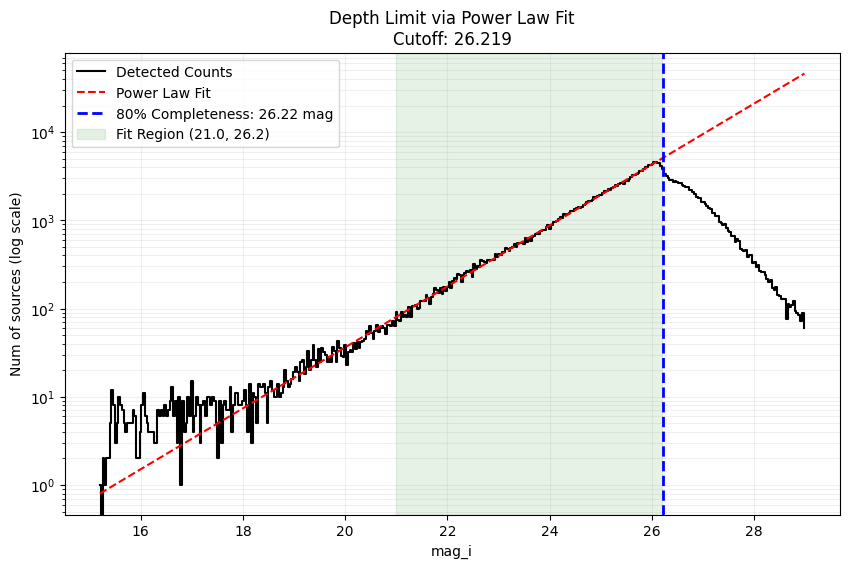

In [15]:
mag_limit = find_mag_limit_power_law(clean_det_cat['mag_i'].values, 
                                     mag_col='mag_i', 
                                     fit_range=(21.0, 26.2),
                                     threshold=0.80, 
                                     bins=400)

Great, the detected counts follow the power law really well in the (21, 26.2) region. With our LSST detection catalog, `26.22` seems to be the detection limit of the pipeline. The sharp drop-off right after 26 also confirms that the pipeline had a hard time resolving objects from background noise.

Text(0.5, 1.0, 'Mag $i$ Distribution of LSST Detection Catalog Objects (270107 objs)')

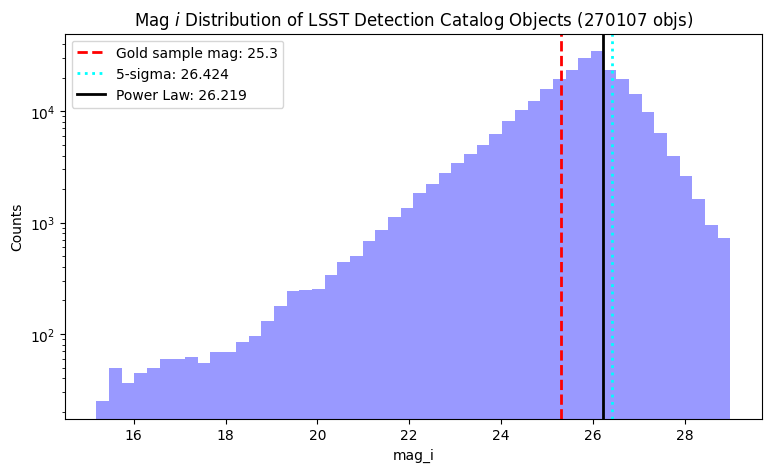

In [16]:
counts, bin_edges = np.histogram(clean_det_cat[np.isfinite(clean_det_cat['mag_i'])]['mag_i'], bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.axvline(25.3, color='red', linestyle='--', linewidth='2', label=f'Gold sample mag: 25.3')
plt.axvline(given_mag_limit, color='cyan', linestyle=':', linewidth='2', label=f'5-sigma: {given_mag_limit:.3f}')
plt.axvline(mag_limit, color='black', linestyle='solid', linewidth='2', label=f'Power Law: {mag_limit:.3f}')
plt.hist(clean_det_cat['mag_i'], bins=50, alpha=0.4, color='blue')
plt.yscale('log')
plt.legend()
plt.title(f"Mag $i$ Distribution of LSST Detection Catalog Objects ({len(clean_det_cat)} objs)")

So, which one do we choose to do our analysis with: **26.22** or **26.42**?

Our main goal is focused on analyzing and characterizing blends. To do this effectively, we have to isolate blending systematics from the detector's sensitivity. By targeting the empirical completeness right where the LSST pipeline's recovery rate begins to lower, we make sure that we're analyzing a space where isolated objects should be detected. Knowing that, we can attribute failures (merged objects or missed detections) primarily to blending rather than low SNR. If we push to the 5-sigma depth of 26.42, we could conflate blending failures with detection failures caused by the faintness. Additionally, if we use the conservative (high purity, low false positives) "gold sample" magnitude of 25.3, we will be ignoring the fact that the pipeline did successfully detect objects between 25.3 and 26.4. Thus, we set our limiting magnitude to be the empirically derived **26.22**.

## LSST Truth Catalog

In [18]:
full_truth_cat = concat_all_cats(all_truth_cats, 'truth') # took ~40s

Columns of truth catalog: ['id', 'mag_r', 'patch', 'flux_g', 'tract', 'mag_z', 'dec', 'mag_y', 'rv', 'ra', 'cosmodc2_hp', 'av', 'mag_g', 'mag_u', 'flux_z', 'host_galaxy', 'flux_i', 'truth_type', 'flux_r', 'cosmodc2_id', 'flux_y', 'mag_i', 'id_string', 'flux_u', 'redshift', 'ellipticity_2_disk_true', 'position_angle_true', 'ellipticity_1_bulge_true', 'bulge_to_total_ratio_i', 'shear_1', 'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed', 'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed', 'ellipticity_1_disk_true', 'mag_true_y', 'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed', 'mag_true_i', 'size_minor_true', 'R_v', 'size_minor_disk_true', 'size_minor_bulge_true', 'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed', 'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed', 'position_angle_true_dc2', 'size_bulge_true', 'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed', 'LSST_filters/diskLuminositiesStellar:LSST_y:observed', 'SDSS_filters/spheroidLuminositiesS

In [19]:
print(len(np.unique(full_truth_cat.id.values)), "unique objects in truth catalog that covers the same cutout areas as the test set.")

1190077 unique objects in truth catalog that covers the same cutout areas as the test set.


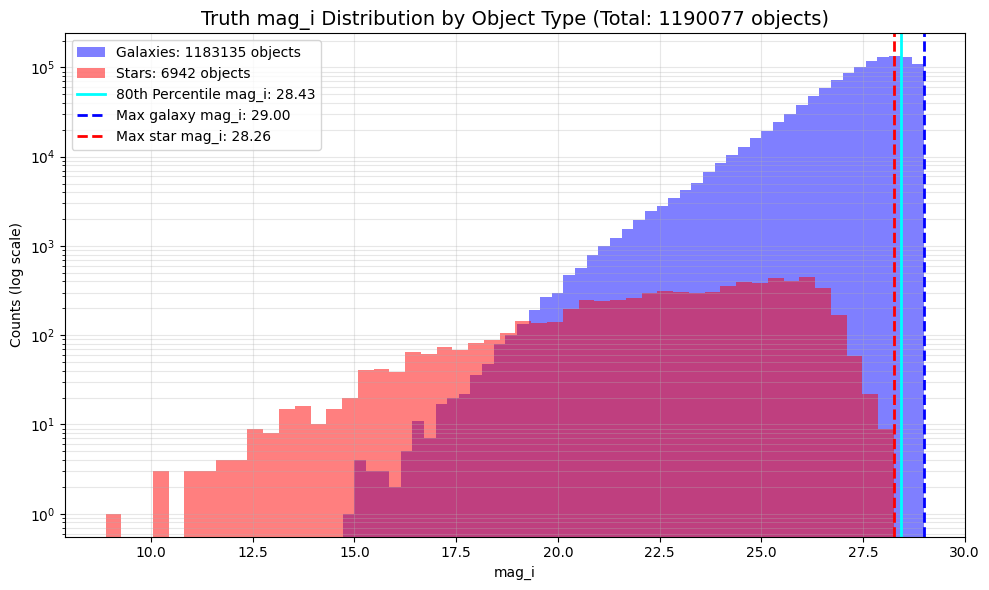

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Galaxies
gals = full_truth_cat[full_truth_cat['truth_type'] == 1]['mag_i']
ax.hist(gals, bins=50, alpha=0.5, color='blue', label=f'Galaxies: {len(gals)} objects')
# Stars
stars = full_truth_cat[full_truth_cat['truth_type'] == 2]['mag_i']
ax.hist(stars, bins=50, alpha=0.5, color='red', label=f'Stars: {len(stars)} objects')
ax.set_yscale('log')
ax.set_xlabel('mag_i')
ax.set_ylabel('Counts (log scale)')
ax.set_title(f'Truth mag_i Distribution by Object Type (Total: {len(full_truth_cat)} objects)', fontsize=14)
ax.axvline(np.percentile(full_truth_cat['mag_i'], 80), color='cyan', linewidth=2, linestyle='solid', label=f'80th Percentile mag_i: {np.percentile(full_truth_cat["mag_i"], 80):.2f}')
ax.axvline(gals.max(), color='blue', linestyle='--', linewidth=2, label=f'Max galaxy mag_i: {gals.max():.2f}')
ax.axvline(stars.max(), color='red', linestyle='--', linewidth=2, label=f'Max star mag_i: {stars.max():.2f}')
ax.grid(True, alpha=0.3, which='both')
ax.legend()
plt.tight_layout()

In [21]:
truth_cat_fn = f'{test_cats_dir}full_test_truth_cat.parquet'
if not full_truth_cat.empty:
    full_truth_cat.to_parquet(truth_cat_fn)
    print(f"Saved truth catalog of {len(full_truth_cat)} objects that span the same cutouts of the test set to {truth_cat_fn}")

Saved truth catalog of 1190077 objects that span the same cutouts of the test set to /u/yse2/lsst_data/test_cats_lvl5/test_8k/full_test_truth_cat.parquet


In [3]:
# read back in truth cat to verify
truth_cat_fn = f'{test_cats_dir}full_test_truth_cat.parquet'
full_truth_cat = pd.read_parquet(truth_cat_fn)
print(f"Read back in truth catalog from {truth_cat_fn} with {len(full_truth_cat)} objects.")

Read back in truth catalog from /u/yse2/lsst_data/test_cats_lvl5/test_8k/full_test_truth_cat.parquet with 1190077 objects.


### Truth Objs With GT Annotations

Before we continue, let's compare the distributions of objects in the test set that only have ground truth annotations against the distribution of objects of `full_truth_cat` which was constructed from concatenating the truth catalogs for each cutout. 

In [22]:
# explode transforms each ele of list-like col into a sep row replicating other col vals
# idx is preserved unless we call reset_index()
# BEFORE img_id 
# 0          1: [{'obj_id': 1234, 'mag_i': 25}, {'obj_id': 5678, 'mag_i': 25}, ...]
# 1          2: [{'obj_id': 4321, 'mag_i': 26}, {'obj_id': 8765, 'mag_i': 26}, ...]
# AFTER  img_id
# 0          1: {'obj_id': 1234, 'mag_i': 25}
# 0          1: {'obj_id': 5678, 'mag_i': 25}
# 1          2: {'obj_id': 4321, 'mag_i': 26}
# 1          2: {'obj_id': 8765, 'mag_i': 26}
# so we explode anns into sep rows and reset idx dropping the old one
test_objs_df = test_data.explode('annotations').reset_index(drop=True) # takes 5.7s for 8571 imgs
test_objs_df = pd.concat([
    test_objs_df.drop('annotations', axis=1), # keep all img metadata cols
    pd.json_normalize(test_objs_df['annotations']) # turn each ann dict into its own cols 
], axis=1) # and then join horizontally
# so now instead of having to do test_objs_df['annotations']['obj_id'] for each row, we have test_objs_df['obj_id']
# giving us a flat table where each row is one object with all its props as cols

In [5]:
test_objs_df

,file_name,image_id,height,width,tile,det_cat_path,truth_cat_path,wcs,obj_id,obj_truth_idx,...,mag_g,flux_g,mag_r,flux_r,mag_i,flux_i,mag_z,flux_z,mag_y,flux_y
0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,73,150,147,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,9502312400,8,...,26.823124,67.725174,26.807194,68.726257,26.462698,94.388794,26.131615,128.042343,26.139370,127.131279
1,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,73,150,147,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,9501803150,9,...,26.825253,67.592682,26.748997,72.510712,26.182444,122.186211,26.001965,144.282669,26.015398,142.508545
2,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,73,150,147,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,9502520267,13,...,24.577278,535.905212,24.309986,685.497375,23.855207,1042.119263,23.289883,1754.069702,23.082096,2124.032715
3,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,73,150,147,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,9502520268,14,...,25.332542,267.290283,24.867851,410.070831,24.306143,687.927979,23.681042,1223.441406,23.453487,1508.704712
4,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,73,150,147,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,9502137039,18,...,26.231693,116.767540,26.293566,110.299545,25.905224,157.728821,25.774319,177.939560,25.825842,169.692719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254751,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,193,144,147,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,8641057299,129,...,26.671621,77.866577,26.581669,84.592613,26.819012,67.982216,26.724087,74.193489,26.630972,80.837296
254752,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,193,144,147,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,8641061146,130,...,24.867125,410.345825,24.977625,370.638000,25.149429,316.393921,25.282211,279.972656,25.341513,265.090881
254753,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,193,144,147,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,8641062913,131,...,26.504164,90.851982,26.480104,92.887642,26.572065,85.344177,26.645918,79.732025,26.668789,78.070091
254754,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,193,144,147,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,8641062914,132,...,26.262819,113.467712,25.955618,150.575012,25.909340,157.131577,25.851543,165.722992,25.685822,193.051056


In [23]:
test_objs_df.columns

Index(['file_name', 'image_id', 'height', 'width', 'tile', 'det_cat_path',
       'truth_cat_path', 'wcs', 'obj_id', 'obj_truth_idx', 'category_id',
       'bbox', 'bbox_mode', 'area', 'segmentation', 'ra', 'dec', 'redshift',
       'size_true', 'ellipticity_1_true', 'ellipticity_2_true', 'mag_u',
       'flux_u', 'mag_g', 'flux_g', 'mag_r', 'flux_r', 'mag_i', 'flux_i',
       'mag_z', 'flux_z', 'mag_y', 'flux_y'],
      dtype='object')

In [23]:
# check if test_objs_df's ids exist in full_truth_cat's ids
print(f"Extracted {len(test_objs_df)} objects with annotations from {len(test_data)} images in test set.")
print(len(np.unique(test_objs_df.obj_id.values)), "unique objects with ground truth annotations in test set.")
matched_ids = test_objs_df['obj_id'].isin(full_truth_cat['id'])
print(f"Number of objects in test_objs_df with obj_id matching full_truth_cat id: {matched_ids.sum()} out of {len(test_objs_df)} total objects.")
missing_objs = full_truth_cat[~full_truth_cat['id'].isin(test_objs_df['obj_id'])]

Extracted 254756 objects with annotations from 8571 images in test set.
254756 unique objects with ground truth annotations in test set.
Number of objects in test_objs_df with obj_id matching full_truth_cat id: 254756 out of 254756 total objects.


So, immediately, we can see that `full_truth_cat` contains 4x more objects than `test_objs_df` but this is expected since our annotation process doesn't create annotations for objects that have low SNR which are a majority of the objects in `full_truth_cat`. We also perform a sanity check confirming that all the objects in our `test_objs_df` do actually exist in `full_truth_cat`. Now, let's take a look at the magnitude distributions

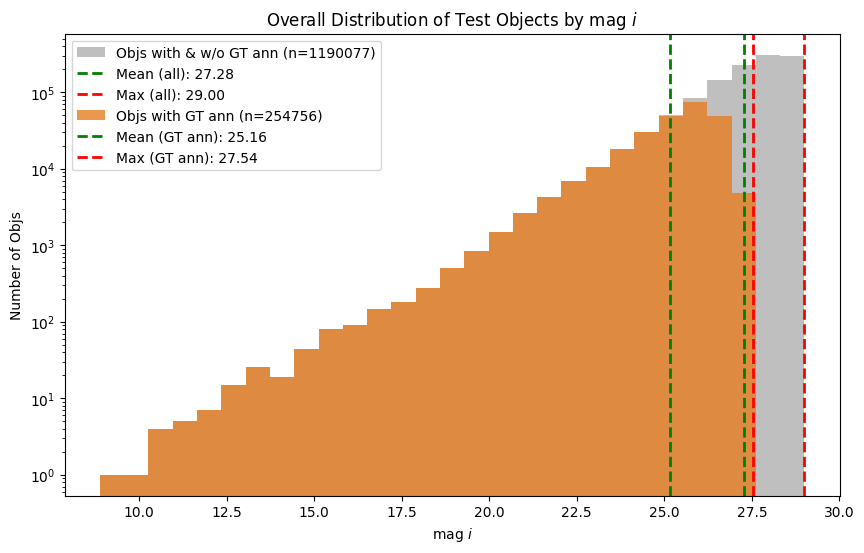

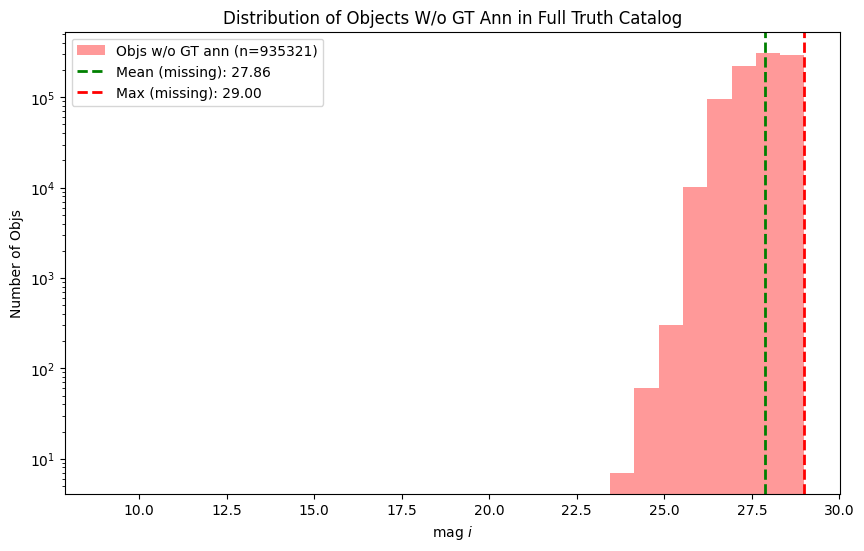

In [7]:
def plot_hist(ax, data, bins, color, label, title=None, show_stats=True, alpha=0.8, stat_suffix=''):
    """
    Plot histogram with optional mean and max statistics.
    
    Parameters:
        ax: matplotlib axis
        data: array-like data to plot
        bins: bin edges for histogram
        color: color for histogram
        label: label for histogram
        title: optional title for plot
        show_stats: whether to show mean/max lines
        alpha: transparency value for histogram
        stat_suffix: suffix to add to mean/max labels (e.g., ' (with GT ann)')
    """
    ax.hist(data, bins=bins, color=color, alpha=alpha, label=label)  
    if show_stats and len(data) > 0:
        mean_val = np.nanmean(data)
        max_val = np.nanmax(data)
        ax.axvline(mean_val, color='green', linestyle='--', linewidth=2, 
                   label=f'Mean{stat_suffix}: {mean_val:.2f}')
        ax.axvline(max_val, color='red', linestyle='--', linewidth=2, 
                   label=f'Max{stat_suffix}: {max_val:.2f}')
    ax.set_xlabel(r'mag $i$')
    ax.set_yscale('log')
    ax.set_ylabel('Number of Objs')
    if title:
        ax.set_title(title)
    ax.legend(frameon=True)

test_mags_i = test_objs_df['mag_i'].values 
full_truth_cat_mags_i = full_truth_cat['mag_i'].values   

bins_full = np.linspace(min(full_truth_cat_mags_i), max(full_truth_cat_mags_i), 30)
bins_test = np.linspace(min(test_mags_i), max(test_mags_i), 30)
bins_to_use = bins_full if (bins_full[-1] - bins_full[0]) > (bins_test[-1] - bins_test[0]) else bins_test
colors = {
    'test': '#e67e22',   # orange
    'stars': '#e74c3c',  # red
    'galaxies': '#3498db',  # blue
}
fig2, ax2 = plt.subplots(figsize=(10, 6))
title = r'Overall Distribution of Test Objects by mag $i$'

# Plot both datasets with different alpha and stat labels
plot_hist(ax2, full_truth_cat_mags_i, bins=bins_to_use, color='gray', 
          label=f'Objs with & w/o GT ann (n={len(full_truth_cat_mags_i)})', 
          show_stats=True, alpha=0.5, stat_suffix=' (all)')
plot_hist(ax2, test_mags_i, bins=bins_to_use, color=colors['test'], 
          label=f'Objs with GT ann (n={len(test_mags_i)})', 
          title=title, show_stats=True, alpha=0.8, stat_suffix=' (GT ann)')
# objs not in test_objs_df
fig3, ax3 = plt.subplots(figsize=(10, 6))
plot_hist(ax3, missing_objs['mag_i'].values, bins=bins_to_use, color='red', 
          label=f'Objs w/o GT ann (n={len(missing_objs)})', 
          title=f'Distribution of Objects W/o GT Ann in Full Truth Catalog',
          show_stats=True, alpha=0.4, stat_suffix=' (missing)')

Great! As we can see, most of the missing objects are fainter mag objects with `mag_i > 27.54`. Let's take a look at some of the brighter objects and find out why they were rejected by our annotation process.

#### Bright Objects w/ No GT Ann

In [7]:
bright_missing = missing_objs[missing_objs['mag_i'] < 25]
print(f"Number of objects in truth catalog NOT in test_objs_df with mag_i < 25: {len(bright_missing)}")
bright_missing 

Number of objects in truth catalog NOT in test_objs_df with mag_i < 25: 98


,id,mag_r,patch,flux_g,tract,mag_z,dec,mag_y,rv,ra,...,size_disk_true,ellipticity_1_true,bulge_to_total_ratio_u,bulge_to_total_ratio_g,bulge_to_total_ratio_r,bulge_to_total_ratio_z,bulge_to_total_ratio_y,cutout_x,cutout_y,file_name
9412,10252187297,25.664062,"5,3",112.217552,3257,24.305965,-40.925838,24.224575,3.1,51.828416,...,0.414903,-0.052037,0.044297,0.066042,0.114058,0.164470,0.176873,80.101376,104.131453,/u/yse2/lsst_data/truth/51.87_-40.9/c146_51.87...
9426,10251334650,25.312166,"5,3",129.842041,3257,24.150612,-40.925919,24.078152,3.1,51.827426,...,0.184785,0.179389,0.000000,0.000000,0.000000,0.000000,0.000000,93.564082,102.557220,/u/yse2/lsst_data/truth/51.87_-40.9/c146_51.87...
9433,10250848829,25.162714,"5,3",133.983017,3257,24.488808,-40.931086,24.420170,3.1,51.829745,...,0.235571,0.047702,0.168546,0.227536,0.304368,0.392685,0.404244,61.256888,9.810457,/u/yse2/lsst_data/truth/51.87_-40.9/c146_51.87...
9434,10250763435,24.983418,"5,3",146.631165,3257,24.317999,-40.930948,24.228111,3.1,51.824713,...,0.252207,-0.020172,0.000000,0.000000,0.000000,0.000000,0.000000,129.713367,11.726664,/u/yse2/lsst_data/truth/51.87_-40.9/c146_51.87...
92782,10252203504,25.436035,"1,2",151.515762,3256,24.171350,-41.205881,24.114588,3.1,51.226746,...,0.556806,-0.021372,0.000000,0.000000,0.000000,0.000000,0.000000,106.013405,16.621661,/u/yse2/lsst_data/truth/51.24_-41.1/c98_51.24_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145138,9502523492,25.270481,"6,3",236.403519,3258,24.309967,-40.887936,24.145920,3.1,53.735061,...,0.614880,0.064892,0.005166,0.016725,0.056369,0.125941,0.145317,103.497116,36.900599,/u/yse2/lsst_data/truth/53.69_-40.9/c213_53.69...
1147703,10251949437,25.817186,"3,1",94.682938,3257,24.497435,-41.345941,24.436417,3.1,52.403767,...,0.159799,-0.476396,0.058194,0.082659,0.143028,0.199964,0.209761,68.307980,43.085313,/u/yse2/lsst_data/truth/52.34_-41.3/c61_52.34_...
1147742,10250053173,24.704548,"3,1",274.387268,3257,24.307711,-41.345035,24.208128,3.1,52.401296,...,0.462223,0.004105,0.000000,0.000000,0.000000,0.000000,0.000000,101.725065,59.337152,/u/yse2/lsst_data/truth/52.34_-41.3/c61_52.34_...
1147806,10262533186,24.765770,"3,1",352.840057,3257,24.387625,-41.342694,24.114777,3.1,52.402883,...,0.374795,-0.099177,1.000000,1.000000,1.000000,1.000000,1.000000,80.347487,101.521151,/u/yse2/lsst_data/truth/52.34_-41.3/c61_52.34_...


In [8]:
# num of each filename and find the one with the most
# bright_missing['file_name'].str.split('/').str[5] to get tile names
file_counts = bright_missing['file_name'].value_counts()
most_common_file = file_counts.idxmax()
most_common_count = file_counts.max()
print(f"File with most rows: {most_common_file}")
print(f"Number of rows: {most_common_count}")
common_bright_obj_ids = bright_missing[bright_missing['file_name'] == most_common_file]['id'].values
print("Object IDs of bright missing objects in that file:", common_bright_obj_ids)

File with most rows: /u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11_-39.1.npy
Number of rows: 9
Object IDs of bright missing objects in that file: [8690018270 8689678334 8688253823 8687814532 8687720550 8687500804
 8687525371 8701189205 8704174984]


In [9]:
tile = most_common_file.split('/')[5]
rejected_objs_root = f'{root_dir}rejected_objs_lvl5/'
rejected_tile_fn = f'{rejected_objs_root}{tile}.json'
rejected_objs_df = pd.read_json(rejected_tile_fn)
rejected_row = rejected_objs_df[rejected_objs_df['file_name'] == most_common_file]
rejected_row

,file_name,image_id,height,width,tile,det_cat_path,truth_cat_path,wcs,rejected_objs
186,/u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...,186,148,149,54.11_-39.1,/u/yse2/lsst_data/truth/54.11_-39.1/det_c186_5...,/u/yse2/lsst_data/truth/54.11_-39.1/truth_c186...,WCSAXES = 2 ...,"[{'obj_id': 8690390945, 'obj_truth_idx': 2, 'c..."


In [10]:
rejected_objs = rejected_row.explode('rejected_objs').reset_index(drop=True)
rejected_objs = pd.concat([
    rejected_objs.drop('rejected_objs', axis=1),
    pd.json_normalize(rejected_objs['rejected_objs'])
], axis=1)
rejected_bright_objs = rejected_objs[rejected_objs['obj_id'].isin(common_bright_obj_ids)]
rejected_bright_objs

,file_name,image_id,height,width,tile,det_cat_path,truth_cat_path,wcs,obj_id,obj_truth_idx,...,mag_g,flux_g,mag_r,flux_r,mag_i,flux_i,mag_z,flux_z,mag_y,flux_y
5,/u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...,186,148,149,54.11_-39.1,/u/yse2/lsst_data/truth/54.11_-39.1/det_c186_5...,/u/yse2/lsst_data/truth/54.11_-39.1/truth_c186...,WCSAXES = 2 ...,8690018270,7,...,24.612141,518.971741,24.297382,693.500122,23.812437,1083.989990,23.312759,1717.498047,23.173454,1952.621948
20,/u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...,186,148,149,54.11_-39.1,/u/yse2/lsst_data/truth/54.11_-39.1/det_c186_5...,/u/yse2/lsst_data/truth/54.11_-39.1/truth_c186...,WCSAXES = 2 ...,8689678334,22,...,25.261993,285.235077,25.257954,286.297882,24.886534,403.075745,24.605881,521.972778,24.625591,512.581970
30,/u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...,186,148,149,54.11_-39.1,/u/yse2/lsst_data/truth/54.11_-39.1/det_c186_5...,/u/yse2/lsst_data/truth/54.11_-39.1/truth_c186...,WCSAXES = 2 ...,8688253823,32,...,26.174797,123.049858,25.420883,246.403290,24.921730,390.218475,24.898552,398.637787,24.866865,410.444580
35,/u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...,186,148,149,54.11_-39.1,/u/yse2/lsst_data/truth/54.11_-39.1/det_c186_5...,/u/yse2/lsst_data/truth/54.11_-39.1/truth_c186...,WCSAXES = 2 ...,8687814532,37,...,26.554562,86.731232,25.204659,300.702057,24.674202,490.139130,24.432865,612.145325,24.287146,700.071533
38,/u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...,186,148,149,54.11_-39.1,/u/yse2/lsst_data/truth/54.11_-39.1/det_c186_5...,/u/yse2/lsst_data/truth/54.11_-39.1/truth_c186...,WCSAXES = 2 ...,8687720550,40,...,26.164425,124.231094,24.954414,378.647156,24.586908,531.173706,24.390358,636.585083,24.258678,718.669556
40,/u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...,186,148,149,54.11_-39.1,/u/yse2/lsst_data/truth/54.11_-39.1/det_c186_5...,/u/yse2/lsst_data/truth/54.11_-39.1/truth_c186...,WCSAXES = 2 ...,8687500804,44,...,24.679199,487.888855,24.159992,787.052002,23.900352,999.675720,23.775415,1121.588989,23.718290,1182.181519
41,/u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...,186,148,149,54.11_-39.1,/u/yse2/lsst_data/truth/54.11_-39.1/det_c186_5...,/u/yse2/lsst_data/truth/54.11_-39.1/truth_c186...,WCSAXES = 2 ...,8687525371,45,...,25.201283,301.638458,24.253199,722.304810,23.837374,1059.377930,23.569376,1355.967773,23.408060,1573.172485
121,/u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...,186,148,149,54.11_-39.1,/u/yse2/lsst_data/truth/54.11_-39.1/det_c186_5...,/u/yse2/lsst_data/truth/54.11_-39.1/truth_c186...,WCSAXES = 2 ...,8701189205,125,...,24.548721,550.188599,24.372484,647.152344,24.381557,641.766724,24.183542,770.164307,23.853870,1043.403198
133,/u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...,186,148,149,54.11_-39.1,/u/yse2/lsst_data/truth/54.11_-39.1/det_c186_5...,/u/yse2/lsst_data/truth/54.11_-39.1/truth_c186...,WCSAXES = 2 ...,8704174984,137,...,24.781847,443.875641,24.733065,464.274323,24.743690,459.752258,24.836399,422.123962,24.843220,419.480713


In [10]:
rejected_bright_objs.columns

Index(['file_name', 'image_id', 'height', 'width', 'tile', 'det_cat_path',
       'truth_cat_path', 'wcs', 'obj_id', 'obj_truth_idx', 'category_id', 'ra',
       'dec', 'redshift', 'size_true', 'ellipticity_1_true',
       'ellipticity_2_true', 'reason', 'mag_u', 'flux_u', 'mag_g', 'flux_g',
       'mag_r', 'flux_r', 'mag_i', 'flux_i', 'mag_z', 'flux_z', 'mag_y',
       'flux_y'],
      dtype='object')

In [11]:
rejected_img = np.load(most_common_file)

In [12]:
r = rejected_img[3, :, :] # i
g = rejected_img[2, :, :] # r
b = rejected_img[1, :, :] # g
pmin = np.percentile([r, g, b], 1)
pmax = np.percentile([r, g, b], 99.5)
stretch = pmax - pmin # ~27.160368
vis_img = make_lupton_rgb(r, g, b, minimum=pmin, stretch=stretch, Q=8)

In [13]:
img_wcs = WCS(rejected_row['wcs'].iloc[0])
skycoords = SkyCoord(ra=rejected_bright_objs['ra'].values * u.deg, dec=rejected_bright_objs['dec'].values * u.deg)
x_pix, y_pix = img_wcs.world_to_pixel(skycoords)
rejected_bright_objs['cutout_x'] = x_pix 
rejected_bright_objs['cutout_y'] = y_pix

/tmp/ipykernel_3860828/3930980001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejected_bright_objs['cutout_x'] = x_pix
/tmp/ipykernel_3860828/3930980001.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejected_bright_objs['cutout_y'] = y_pix


In [14]:
rejected_bright_objs['category_id'].value_counts()

category_id
0    9
Name: count, dtype: int64

In [15]:
rejected_bright_objs['reason'].value_counts()

reason
empty_mask    9
Name: count, dtype: int64

So, all of these objects were galaxies rejected because they had an empty segmentation mask. Let's keep investigating

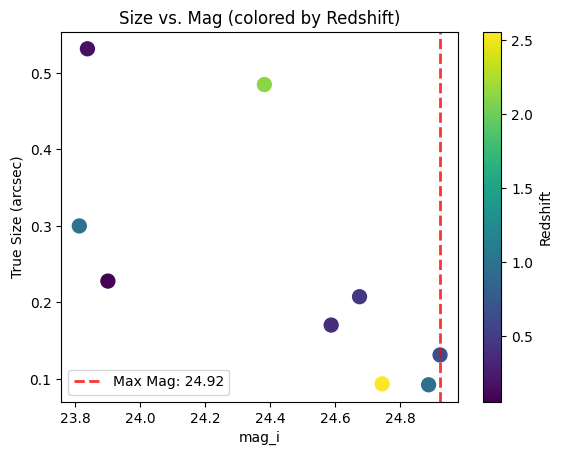

In [16]:
scatter = plt.scatter(rejected_bright_objs['mag_i'], rejected_bright_objs['size_true'], c=rejected_bright_objs['redshift'], 
                      alpha=1, cmap='viridis', s=100)
min_mag = np.min(rejected_bright_objs['mag_i'])
max_mag = np.max(rejected_bright_objs['mag_i'])
plt.axvline(x=max_mag, color='red', linestyle='--', label=f'Max Mag: {max_mag:.2f}', linewidth=2, alpha=0.8)
plt.legend()
plt.xlabel('mag_i')
plt.ylabel('True Size (arcsec)')
plt.title('Size vs. Mag (colored by Redshift)')
plt.colorbar(scatter, label='Redshift')

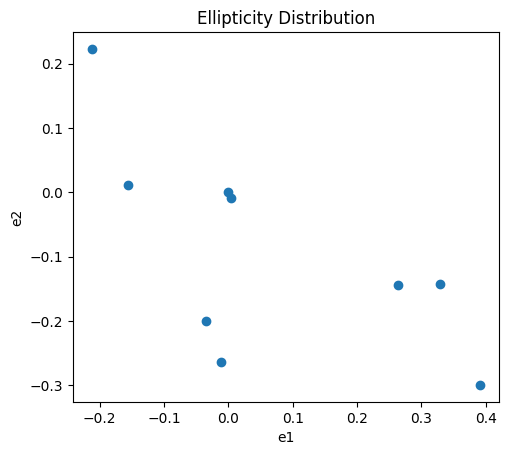

In [17]:
plt.scatter(rejected_bright_objs['ellipticity_1_true'],rejected_bright_objs['ellipticity_2_true'])
plt.xlabel('e1')
plt.ylabel('e2')
plt.title('Ellipticity Distribution')
plt.gca().set_aspect('equal')

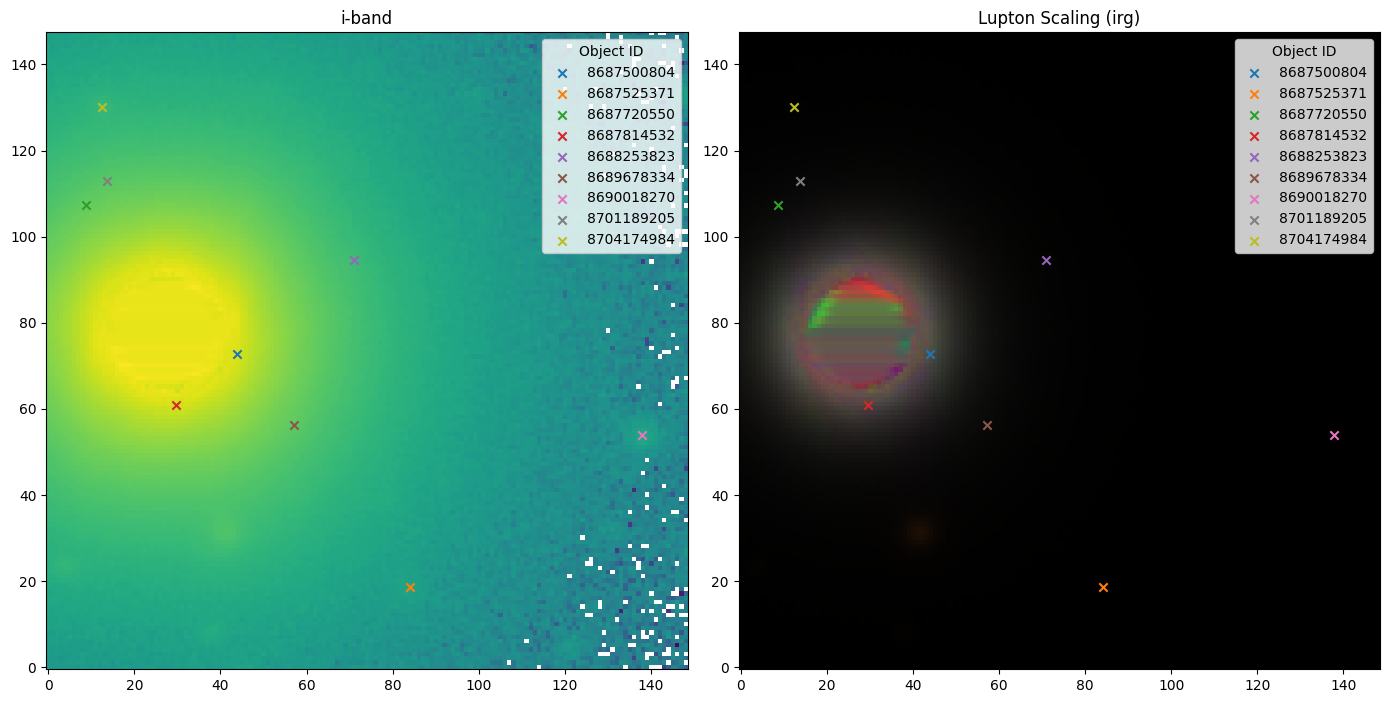

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(b, origin='lower', norm=colors.LogNorm())
for obj_id, group in rejected_bright_objs.groupby('obj_id'):
    axes[0].scatter(group['cutout_x'], group['cutout_y'], marker='x', label=str(obj_id))
# axes[0].scatter(rejected_bright_objs['cutout_x'], rejected_bright_objs['cutout_y'], marker='x', c=['red'], label='Truth')
axes[0].legend(title="Object ID")
axes[0].set_title('i-band')
axes[1].imshow(vis_img, origin='lower')
for obj_id, group in rejected_bright_objs.groupby('obj_id'):
    axes[1].scatter(group['cutout_x'], group['cutout_y'], marker='x', label=str(obj_id))
axes[1].legend(title="Object ID")
axes[1].set_title('Lupton Scaling (irg)')
plt.tight_layout()

Let's pick Object 8690018270 out of these 9 objects and inspect its properties more closely. 

In [16]:
target_obj_id = 8690018270
target_obj_full_props = full_truth_cat.loc[full_truth_cat['id'] == target_obj_id]
target_obj_full_props.to_dict()
# noise = np.array([sigma_clipped_stats(img)[-1] for img in lsst_img])

{'id': {1053115: 8690018270},
 'mag_r': {1053115: 24.2973823547},
 'patch': {1053115: '0,4'},
 'flux_g': {1053115: 518.9717407227},
 'tract': {1053115: 3443},
 'mag_z': {1053115: 23.3127593994},
 'dec': {1053115: -39.1540766404},
 'mag_y': {1053115: 23.1734542847},
 'rv': {1053115: 3.0999999046},
 'ra': {1053115: 54.1113545607},
 'cosmodc2_hp': {1053115: 9939},
 'av': {1053115: 0.053320352},
 'mag_g': {1053115: 24.6121406555},
 'mag_u': {1053115: 24.4227237701},
 'flux_z': {1053115: 1717.498046875},
 'host_galaxy': {1053115: -1},
 'flux_i': {1053115: 1083.9899902344},
 'truth_type': {1053115: 1},
 'flux_r': {1053115: 693.5001220703},
 'cosmodc2_id': {1053115: 8690018270},
 'flux_y': {1053115: 1952.6219482422},
 'mag_i': {1053115: 23.8124370575},
 'id_string': {1053115: 8690018270},
 'flux_u': {1053115: 617.8884277344},
 'redshift': {1053115: 1.0148448944},
 'ellipticity_2_disk_true': {1053115: 0.2297622561},
 'position_angle_true': {1053115: -113.265007019},
 'ellipticity_1_bulge_true'

In [17]:
from astropy.stats import sigma_clipped_stats
# noise of our image
noise = np.array([sigma_clipped_stats(img)[-1] for img in rejected_img])
noise

array([0.35226396, 0.56880975, 0.6767647 , 0.7557051 , 0.7933665 ,
       1.0214342 ], dtype=float32)

In [18]:
import btk
survey = btk.survey.get_surveys("LSST")
bands = ["u", "g", "r", "i", "z", "y"]
fwhm = {b: survey.get_filter(b).psf.calculateFWHM() for b in bands}
print(fwhm)

{'u': np.float64(0.9051806638959863), 'g': np.float64(0.8667200560989293), 'r': np.float64(0.818555886869335), 'i': np.float64(0.8003397403887131), 'z': np.float64(0.7819094381743001), 'y': np.float64(0.7733387230228075)}


In [19]:
r_disk = target_obj_full_props['size_disk_true'].iloc[0]
zp = 27.0 # of DC2 coadds
snr_thresh = 5.0
ps = 0.2 # arcsec/pix
def peak_flux_and_snr(mag, fwhm_arcsec, noise_sigma, r_disk,
                      zp=zp, pixel_scale=ps, snr_thresh=5.0):
    """
    Compute ~ peak flux (counts/pixel) and achieved SNR for one band,
    approximating the galaxy as an exponential disk and the PSF as Gaussian
    """
    # Total flux from mag
    flux = 10**((zp - mag) / 2.5)
    # sizes to pixels
    #    Exponential disk: sigma_obj ≈ r_eff / 1.68
    sigma_obj_pix = (r_disk / pixel_scale) / 1.68
    #    Gaussian PSF: sigma_psf = FWHM / 2.355
    sigma_psf_pix = (fwhm_arcsec / 2.355) / pixel_scale
    # Effective width after Object * PSF * PSF
    sigma_tot_pix = np.sqrt(sigma_obj_pix**2 + 2.0 * sigma_psf_pix**2)
    # Peak flux of 2D Gaussian with total flux 'flux'
    peak_flux = flux / (2.0 * np.pi * sigma_tot_pix**2)
    # 5) Noise after matched filter:
    #    Var_conv = noise^2 * sum(PSF^2), with sum(PSF^2) = 1 / (4 π σ_psf^2)
    psf_fac = 1.0 / (4.0 * np.pi * sigma_psf_pix**2)
    noise_conv = noise_sigma * np.sqrt(psf_fac)
    # 6) Achieved SNR and threshold
    snr_achieved = peak_flux / noise_conv
    return {
        "flux_total": flux,
        "peak_flux": peak_flux,
        "noise_conv": noise_conv,
        "snr": snr_achieved,
        "threshold": snr_thresh,
    }
results = {}
for i, band in enumerate(bands):
    res = peak_flux_and_snr(
        mag=target_obj_full_props[f'mag_{band}'].iloc[0],
        fwhm_arcsec=fwhm[band],
        noise_sigma=noise[i],
        r_disk=r_disk
    )
    results[band] = res
results

{'u': {'flux_total': np.float64(10.737680860621797),
  'peak_flux': np.float64(0.20802531926976414),
  'noise_conv': np.float64(0.05170694945323293),
  'snr': np.float64(4.02315977773772),
  'threshold': 5.0},
 'g': {'flux_total': np.float64(9.01869578651631),
  'peak_flux': np.float64(0.18884607942576692),
  'noise_conv': np.float64(0.08719752517907421),
  'snr': np.float64(2.1657275139167194),
  'threshold': 5.0},
 'r': {'flux_total': np.float64(12.051665195078387),
  'peak_flux': np.float64(0.27923925627568696),
  'noise_conv': np.float64(0.10985133871537422),
  'snr': np.float64(2.5419740855338895),
  'threshold': 5.0},
 'i': {'flux_total': np.float64(18.837582919084003),
  'peak_flux': np.float64(0.4540442077195329),
  'noise_conv': np.float64(0.1254567279992318),
  'snr': np.float64(3.619129997733666),
  'threshold': 5.0},
 'z': {'flux_total': np.float64(29.846694494066437),
  'peak_flux': np.float64(0.7492286106158099),
  'noise_conv': np.float64(0.13481349680842855),
  'snr': n

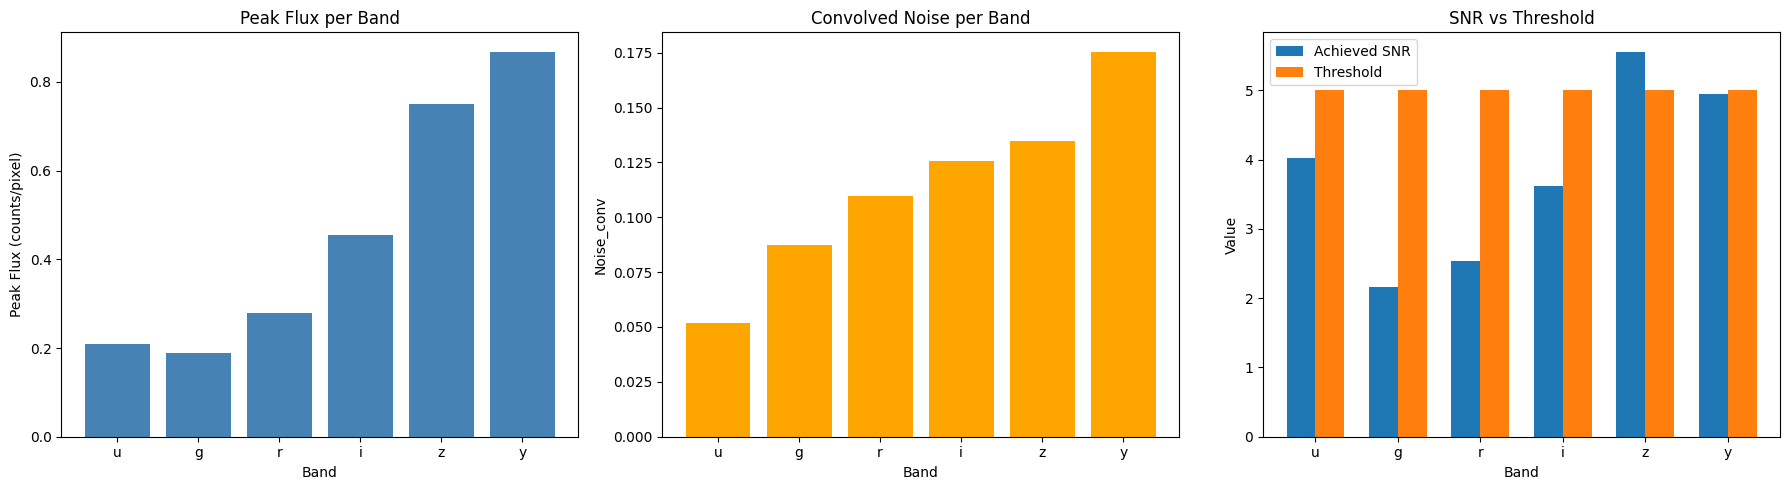

In [20]:
df = pd.DataFrame(results).T  # rows = bands
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Peak flux ---
axes[0].bar(df.index, df['peak_flux'], color='steelblue')
axes[0].set_title("Peak Flux per Band")
axes[0].set_xlabel("Band")
axes[0].set_ylabel("Peak Flux (counts/pixel)")

# --- Noise after convolution ---
axes[1].bar(df.index, df['noise_conv'], color='orange')
axes[1].set_title("Convolved Noise per Band")
axes[1].set_xlabel("Band")
axes[1].set_ylabel("Noise_conv")

# --- SNR vs threshold ---
width = 0.35
x = np.arange(len(df.index))

axes[2].bar(x - width/2, df['snr'], width, label='Achieved SNR')
axes[2].bar(x + width/2, df['threshold'], width, label='Threshold')

axes[2].set_xticks(x)
axes[2].set_xticklabels(df.index)
axes[2].set_title("SNR vs Threshold")
axes[2].set_xlabel("Band")
axes[2].set_ylabel("Value")
axes[2].legend()

plt.tight_layout()

**Given all the above statistics and object properties, why did these objects get rejected by our annotation process?**

Let's discuss the specific example object we chose (Object 8690018270). This object was rejected because of its Low Surface Brightness (LSB), which caused it to fail our SNR and minimum size criteria in the annotation pipeline. Although the object's i-band magnitude suggests it is detectable, its light is spread over a large disk profile, diluting the signal below the detection threshold in 5 of the 6 bands as shown above in the plot. The bulge-to-total ratios confirm that these objects have a Disk (Sérsic $n=1$) profile, which spreads light over a wider, flatter profile ($R_{eff} \approx 0.306''$) rather than a concentrated bulge:

$B/T_i = 0.02$ (2% bulge, 98% disk)
$B/T_z = 0.03$

This means the "Peak Flux" (central pixel brightness) is significantly lower than it would be for a compact source of the same total magnitude.

Our annotation code uses a matched-filter detection algorithm that requires the peak pixel value of the convolved object to exceed a $5\sigma$ noise threshold

$\text{Peak Flux} > 5 \times \sigma_{\text{noise}} \times \sqrt{\sum \text{PSF}^2} $

For the simple calculation above, I assumes the object is perfectly centered on a pixel and after the calculation above, in u, g, r, i, and y bands, the peak flux was strictly below the $5\sigma$ limit. While the z-band was theoretically detectable (SNR ~5.5), pixelization effects (peak splitting between pixels) that I didn't handle likely pushed the peak signal just below the $5.0\sigma$ threshold.

As such, we infer that most of these 98 bright objects (`mag_i < 25`) are LSB galaxies that are too diffuse to pass the peak-flux threshold and resulted in a empty or small segmentation mask.

### Adding GT Annotations to Objects in `full_truth_cat`

To make our lives easier in the future, let's add all the information and metadata of the objects that have ground truth annotations to the corresponding entry in full_truth_cat.

In [25]:
test_objs_df.columns

Index(['file_name', 'image_id', 'height', 'width', 'tile', 'det_cat_path',
       'truth_cat_path', 'wcs', 'obj_id', 'obj_truth_idx', 'category_id',
       'bbox', 'bbox_mode', 'area', 'segmentation', 'ra', 'dec', 'redshift',
       'size_true', 'ellipticity_1_true', 'ellipticity_2_true', 'mag_u',
       'flux_u', 'mag_g', 'flux_g', 'mag_r', 'flux_r', 'mag_i', 'flux_i',
       'mag_z', 'flux_z', 'mag_y', 'flux_y'],
      dtype='object')

The only columns we will be keeping are:
```
Index([image_id', 'height', 'width', 'tile', 'det_cat_path',
       'truth_cat_path', 'wcs', 'obj_id', ,
       'bbox', 'bbox_mode', 'segmentation',
```
Everything else already exists in `full_truth_cat` or is unnecessary.

In [35]:
ann_cols = ['obj_id', 'image_id', 'height', 'width', 'tile', 'det_cat_path', 'truth_cat_path', 'wcs', 
            'bbox', 'bbox_mode', 'segmentation']

In [36]:
test_objs_subset = test_objs_df[ann_cols].copy()
test_objs_subset

,obj_id,image_id,height,width,tile,det_cat_path,truth_cat_path,wcs,bbox,bbox_mode,segmentation
0,9502312400,73,150,147,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[85.5, 135.5, 11, 11]",1,"[[91, 140, 90, 141, 90, 142, 91, 143, 92, 143,..."
1,9501803150,73,150,147,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[47.5, 85.5, 11, 11]",1,"[[53, 90, 52, 91, 52, 92, 53, 93, 54, 93, 55, ..."
2,9502520267,73,150,147,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[40.5, 121.5, 23, 23]",1,"[[52, 126, 51, 127, 49, 127, 46, 130, 46, 131,..."
3,9502520268,73,150,147,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[42.5, 129.5, 21, 21]",1,"[[51, 134, 48, 137, 48, 139, 47, 140, 48, 141,..."
4,9502137039,73,150,147,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[9.5, 5.5, 15, 15]",1,"[[16, 10, 14, 12, 14, 15, 16, 17, 19, 17, 21, ..."
...,...,...,...,...,...,...,...,...,...,...,...
254751,8641057299,193,144,147,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[25.5, 126.5, 13, 13]",1,"[[32, 131, 30, 133, 30, 134, 32, 136, 33, 136,..."
254752,8641061146,193,144,147,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[83.5, -2.5, 21, 21]",1,"[[93, 2, 92, 3, 91, 3, 89, 5, 89, 6, 88, 7, 88..."
254753,8641062913,193,144,147,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[108.5, 27.5, 13, 13]",1,"[[114, 32, 113, 33, 113, 36, 114, 37, 117, 37,..."
254754,8641062914,193,144,147,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[92.5, 4.5, 15, 15]",1,"[[99, 9, 97, 11, 97, 14, 99, 16, 102, 16, 104,..."


In [32]:
# check if test_objs_df's ids exist in full_truth_cat's ids
print(f"Extracted {len(test_objs_df)} objects with annotations from {len(test_data)} images in test set.")
print(len(np.unique(test_objs_df.obj_id.values)), "unique objects with ground truth annotations in test set.")
matched_ids = test_objs_df['obj_id'].isin(full_truth_cat['id'])
print(f"Number of objects in test_objs_df with obj_id matching full_truth_cat id: {matched_ids.sum()} out of {len(test_objs_df)} total objects.")

Extracted 254756 objects with annotations from 8571 images in test set.
254756 unique objects with ground truth annotations in test set.
Number of objects in test_objs_df with obj_id matching full_truth_cat id: 254756 out of 254756 total objects.


In [22]:
full_truth_cat.columns

Index(['id', 'mag_r', 'patch', 'flux_g', 'tract', 'mag_z', 'dec', 'mag_y',
       'rv', 'ra', 'cosmodc2_hp', 'av', 'mag_g', 'mag_u', 'flux_z',
       'host_galaxy', 'flux_i', 'truth_type', 'flux_r', 'cosmodc2_id',
       'flux_y', 'mag_i', 'id_string', 'flux_u', 'redshift',
       'ellipticity_2_disk_true', 'position_angle_true',
       'ellipticity_1_bulge_true', 'bulge_to_total_ratio_i', 'shear_1',
       'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed',
       'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed',
       'ellipticity_1_disk_true', 'mag_true_y',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed',
       'mag_true_i', 'size_minor_true', 'R_v', 'size_minor_disk_true',
       'size_minor_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed',
       'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed',
       'position_angle_true_dc2', 'size_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed',
      

In [37]:
full_truth_cat_anns = full_truth_cat.merge(
    test_objs_subset,
    left_on='id',
    right_on='obj_id',
    how='left'  # keeps all rows in full_truth_cat; adds NaN for non-test objects
)
full_truth_cat_anns = full_truth_cat_anns.drop(columns=['obj_id'])
# took ~2 mins

In [39]:
full_truth_cat_anns.columns

Index(['id', 'mag_r', 'patch', 'flux_g', 'tract', 'mag_z', 'dec', 'mag_y',
       'rv', 'ra', 'cosmodc2_hp', 'av', 'mag_g', 'mag_u', 'flux_z',
       'host_galaxy', 'flux_i', 'truth_type', 'flux_r', 'cosmodc2_id',
       'flux_y', 'mag_i', 'id_string', 'flux_u', 'redshift',
       'ellipticity_2_disk_true', 'position_angle_true',
       'ellipticity_1_bulge_true', 'bulge_to_total_ratio_i', 'shear_1',
       'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed',
       'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed',
       'ellipticity_1_disk_true', 'mag_true_y',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed',
       'mag_true_i', 'size_minor_true', 'R_v', 'size_minor_disk_true',
       'size_minor_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed',
       'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed',
       'position_angle_true_dc2', 'size_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed',
      

In [41]:
full_truth_cat_anns.iloc[1190073]['segmentation']

[[120,
  133,
  119,
  134,
  119,
  135,
  120,
  136,
  121,
  136,
  122,
  135,
  122,
  134,
  121,
  133]]

In [42]:
truth_cat_fn = f'{test_cats_dir}full_test_truth_cat_anns.parquet'
if not full_truth_cat_anns.empty:
    full_truth_cat_anns.to_parquet(truth_cat_fn)
    print(f"Saved truth catalog of {len(full_truth_cat_anns)} objects with annotations that span the same cutouts of the test set to {truth_cat_fn}")

Saved truth catalog of 1190077 objects with annotations that span the same cutouts of the test set to /u/yse2/lsst_data/test_cats_lvl5/test_8k/full_test_truth_cat_anns.parquet


In [17]:
# read back in truth cat with anns
truth_cat_fn = f'{test_cats_dir}full_test_truth_cat_anns.parquet'
full_truth_cat = pd.read_parquet(truth_cat_fn)
print(f"Read back in truth catalog with annotations from {truth_cat_fn} with {len(full_truth_cat)} objects.")

Read back in truth catalog with annotations from /u/yse2/lsst_data/test_cats_lvl5/test_8k/full_test_truth_cat_anns.parquet with 1190077 objects.


### Magnitude Cuts on Truth Catalog

In [18]:
print(f"Power Law: {mag_limit:3f}\n5-sigma: {given_mag_limit:3f}\nGold Sample: 25.30")

Power Law: 26.219151
5-sigma: 26.423713
Gold Sample: 25.30


We choose a [1,2]-magnitude buffer to ensure that our analysis will capture blended neighbors that are significantly fainter than the matched object but still contribute flux. This way, we can account for situations where the matched galaxy blends with a much fainter source that would've otherwise been undetectable in a shallower catalog. This also avoids incorrectly classifying a blended system as a 1-1 match simply because the fainter galaxy fell below the detection limit of the survey. 

In [19]:
buffer = [1, 2]
mag_limit_w_buffer = [mag_limit + b for b in buffer]
given_mag_limit_w_buffer = [given_mag_limit + b for b in buffer]
gold_sample_w_buffer = [25.3 + b for b in buffer]
print(f"Applying {buffer}-mag buffer to power law mag limit: {mag_limit_w_buffer}")
print(f"Applying {buffer}-mag buffer to 5-sigma limit: {given_mag_limit_w_buffer}")
print(f"Applying {buffer}-mag buffer to gold sample: {gold_sample_w_buffer}")

Applying [1, 2]-mag buffer to power law mag limit: [np.float64(27.219151142047), np.float64(28.219151142047)]
Applying [1, 2]-mag buffer to 5-sigma limit: [np.float64(27.423712505420024), np.float64(28.423712505420024)]
Applying [1, 2]-mag buffer to gold sample: [26.3, 27.3]


In [20]:
def save_mag_limited_truth_cat(full_truth_cat, mag_limit, buffer):
    mag_limit_w_buffer = mag_limit + buffer
    print(f"Using {buffer}-mag buffer on mag limit: {mag_limit_w_buffer:2f} for full truth catalog...")
    maglim_truth_cat = full_truth_cat[full_truth_cat['mag_i'] <= mag_limit_w_buffer]
    print(f"Filtered full truth catalog from {len(full_truth_cat)} to {len(maglim_truth_cat)} objects with mag_i <= {mag_limit_w_buffer:.2f}")
    save_fn = f'{test_cats_dir}test_truth_cat_maglim_{mag_limit_w_buffer:.2f}.parquet'
    maglim_truth_cat = maglim_truth_cat.reset_index(drop=True) # reset index before saving
    maglim_truth_cat.to_parquet(save_fn)
    print(f"Saved mag-limited truth catalog to {save_fn}")
    return maglim_truth_cat

In [21]:
buffers = [1, 2]
mag_limits = [mag_limit, given_mag_limit, 25.3]
for buffer in buffers:
    for ml in mag_limits:
        maglim_truth_cat = save_mag_limited_truth_cat(full_truth_cat, ml, buffer=buffer)

Using 1-mag buffer on mag limit: 27.219151 for full truth catalog...
Filtered full truth catalog from 1190077 to 444011 objects with mag_i <= 27.22
Saved mag-limited truth catalog to /u/yse2/lsst_data/test_cats_lvl5/test_8k/test_truth_cat_maglim_27.22.parquet
Using 1-mag buffer on mag limit: 27.423713 for full truth catalog...
Filtered full truth catalog from 1190077 to 512444 objects with mag_i <= 27.42
Saved mag-limited truth catalog to /u/yse2/lsst_data/test_cats_lvl5/test_8k/test_truth_cat_maglim_27.42.parquet
Using 1-mag buffer on mag limit: 26.300000 for full truth catalog...
Filtered full truth catalog from 1190077 to 224192 objects with mag_i <= 26.30
Saved mag-limited truth catalog to /u/yse2/lsst_data/test_cats_lvl5/test_8k/test_truth_cat_maglim_26.30.parquet
Using 2-mag buffer on mag limit: 28.219151 for full truth catalog...
Filtered full truth catalog from 1190077 to 853631 objects with mag_i <= 28.22
Saved mag-limited truth catalog to /u/yse2/lsst_data/test_cats_lvl5/test

### Comparison Plots of Different Mag Limits and Buffers on mag_i Distribution

In [26]:
counts, bin_edges = np.histogram(full_truth_cat[np.isfinite(full_truth_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2

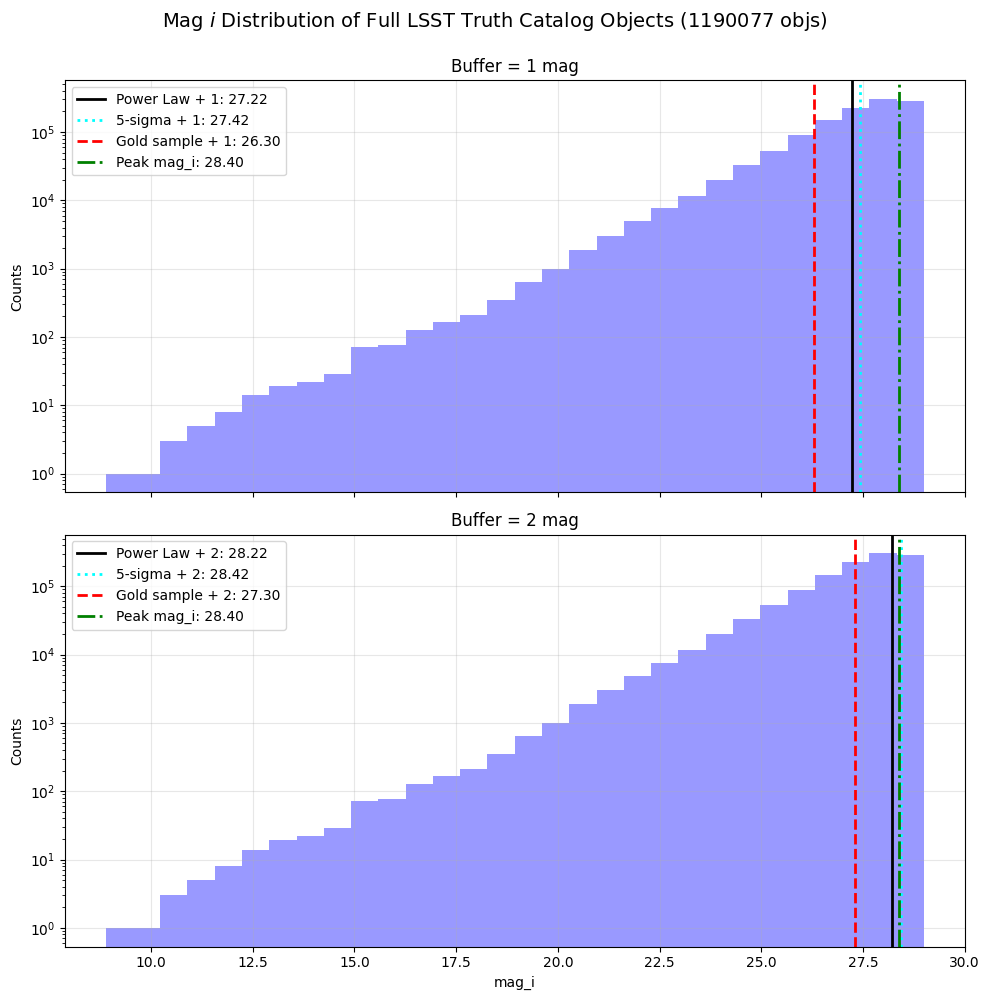

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1.axvline(mag_limit + 1, color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limit + 1:.2f}')
ax1.axvline(given_mag_limit + 1, color='cyan', linestyle=':', linewidth=2, label=f'5-sigma + 1: {given_mag_limit + 1:.2f}')
ax1.axvline(25.3 + 1, color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {26.3:.2f}')
ax1.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
ax1.hist(full_truth_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
ax1.set_ylabel('Counts')
ax1.set_yscale('log')
ax1.set_title('Buffer = 1 mag')
ax1.legend()
ax1.grid(True, alpha=0.3)

# buffer = 2
ax2.axvline(mag_limit + 2, color='black', linestyle='solid', linewidth=2, label=f'Power Law + 2: {mag_limit + 2:.2f}')
ax2.axvline(given_mag_limit + 2, color='cyan', linestyle=':', linewidth=2, label=f'5-sigma + 2: {given_mag_limit + 2:.2f}')
ax2.axvline(25.3 + 2, color='red', linestyle='--', linewidth=2, label=f'Gold sample + 2: {27.3:.2f}')
ax2.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
ax2.hist(full_truth_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
ax2.set_xlabel('mag_i')
ax2.set_ylabel('Counts')
ax2.set_yscale('log')
ax2.set_title('Buffer = 2 mag')
ax2.legend()
ax2.grid(True, alpha=0.3)
fig.suptitle(f"Mag $i$ Distribution of Full LSST Truth Catalog Objects ({len(full_truth_cat)} objs)", fontsize=14, y=0.995)
plt.tight_layout()

### Plotting Class-Specific Mag Limited Distributions

In [28]:
maglim_truth_cat = pd.read_parquet(f'{test_cats_dir}test_truth_cat_maglim_{gold_sample_w_buffer[0]}0.parquet')

In [29]:
maglim_truth_cat['mag_i'].describe()

count    224192.000000
mean         24.930192
std           1.396033
min           8.881651
25%          24.406944
50%          25.363270
75%          25.918063
max          26.299999
Name: mag_i, dtype: float64

In [30]:
counts, bin_edges = np.histogram(maglim_truth_cat[np.isfinite(maglim_truth_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
peak_mag

np.float64(26.125815753976)

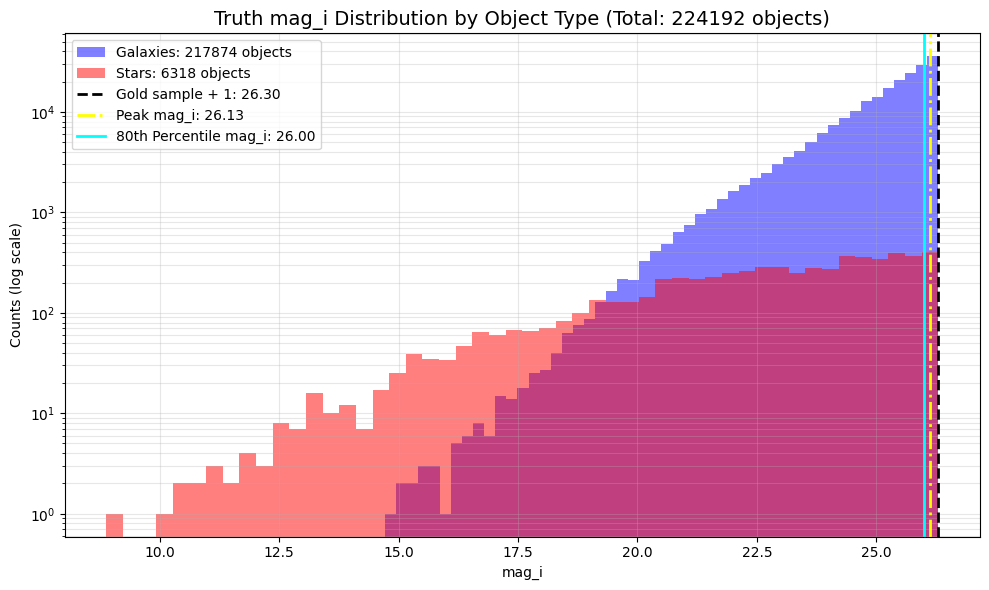

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Galaxies
gals = maglim_truth_cat[maglim_truth_cat['truth_type'] == 1]['mag_i']
ax.hist(gals, bins=50, alpha=0.5, color='blue', label=f'Galaxies: {len(gals)} objects')
# Stars
stars = maglim_truth_cat[maglim_truth_cat['truth_type'] == 2]['mag_i']
ax.hist(stars, bins=50, alpha=0.5, color='red', label=f'Stars: {len(stars)} objects')
ax.set_yscale('log')
ax.set_xlabel('mag_i')
ax.set_ylabel('Counts (log scale)')
plt.title(f"Mag $i$ <= {25.3 + 1} Distribution of LSST Truth Catalog ({len(maglim_truth_cat)} objs)", fontsize=14)
ax.set_title(f'Truth mag_i Distribution by Object Type (Total: {len(maglim_truth_cat)} objects)', fontsize=14)
plt.axvline(25.3 + 1, color='black', linestyle='--', linewidth=2, label=f'Gold sample + 1: {26.3:.2f}')
plt.axvline(peak_mag, color='yellow', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
ax.axvline(np.percentile(maglim_truth_cat['mag_i'], 80), color='cyan', linewidth=2, linestyle='solid', label=f'80th Percentile mag_i: {np.percentile(maglim_truth_cat["mag_i"], 80):.2f}')
ax.grid(True, alpha=0.3, which='both')
ax.legend(frameon=True)
plt.tight_layout()